In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno

from sklearn.preprocessing import LabelEncoder, minmax_scale,StandardScaler

from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold,mutual_info_classif,SelectKBest,SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import  RandomForestClassifier

from sklearn.model_selection import  GridSearchCV,cross_val_score,TimeSeriesSplit

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, recall_score, precision_score, roc_auc_score,roc_curve, auc,matthews_corrcoef

Reading csv files

In [2]:
identity = pd.read_csv ('train_identity.csv')
transaction = pd.read_csv ('train_transaction.csv')

In [3]:
transaction.shape

(590540, 394)

In [4]:
identity.shape

(144233, 41)

Merging transaction and identity files of dataset

In [5]:
#Merging both the files on the basis of TransactionID column(left outer join)
Data = pd.merge(transaction,identity, on='TransactionID', how='left',left_index=True,right_index=True)
print('MERGED')

MERGED


In [6]:
#Deleting tables since we merged it 
del transaction
del identity
print('DELETED')

DELETED


In [7]:
## Function to reduce the size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [8]:
## REducing memory
Data = reduce_mem_usage(Data)

Mem. usage decreased to 645.97 Mb (67.0% reduction)


INITIAL ANALYSIS

In [9]:
Data.shape

(590540, 434)

In [10]:
Data.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ...  samsung browser 6.2   32.0   
1  404.0  150.0  mastercard  102.0  ...   mobile safari 11.0   32.0   
2  490.0  150.0        visa  166.0  ...          chrome 62.0    NaN   
3  567.0  150.0  mastercard  117.0  ...          chrome 62.0    NaN   
4  514.0  150.0  mastercard  102.0  ...          chrome 62.0   24.0   

       id_33           id_34  id_35 id_36 id_37  id_38  DeviceType  \
0  2220x1080  match_status:2      T     F     T      T      mobile   
1   1334x750  match_status:1      T     F     F      T      mobile   
2        NaN             NaN      F     F     T      T     desktop   
3        NaN             NaN      F     F     T      T     desktop   
4   1280x800  match_status:2      T     F     T      T     desktop   

                      DeviceInfo  
0  SAMSUNG SM-G892A Build/NRD90M  
1                     iOS Device  
2                        Windows  
3                            NaN  
4                          MacOS  

[5 rows x 434 columns]

In [11]:
Data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 434 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   590540 non-null  int32  
 1   isFraud         590540 non-null  int8   
 2   TransactionDT   590540 non-null  int32  
 3   TransactionAmt  590540 non-null  float16
 4   ProductCD       590540 non-null  object 
 5   card1           590540 non-null  int16  
 6   card2           581607 non-null  float16
 7   card3           588975 non-null  float16
 8   card4           588963 non-null  object 
 9   card5           586281 non-null  float16
 10  card6           588969 non-null  object 
 11  addr1           524834 non-null  float16
 12  addr2           524834 non-null  float16
 13  dist1           238269 non-null  float16
 14  dist2           37627 non-null   float16
 15  P_emaildomain   496084 non-null  object 
 16  R_emaildomain   137291 non-null  object 
 17  C1       

In [12]:
# summary of columns
total_missing = Data.isnull().sum().sort_values(ascending = False)
percent_missing = (Data.isnull().sum()/Data.isnull().count()*100).sort_values(ascending = False)
datatype = Data.dtypes
unique = Data.nunique()
summary_train = pd.concat([total_missing, percent_missing,datatype,unique], axis=1, keys=['Total_missing', 'Percent_missing','datatype','unique'])
summary_train.head(50)

Total_missing  Percent_missing datatype  unique
id_24         585793        99.196159  float16      12
id_25         585408        99.130965  float16     341
id_07         585385        99.127070  float16      84
id_08         585385        99.127070  float16      94
id_21         585381        99.126393  float16     490
id_26         585377        99.125715  float16      95
id_22         585371        99.124699  float16      25
id_23         585371        99.124699   object       3
id_27         585371        99.124699   object       2
dist2         552913        93.628374  float16    1699
D7            551623        93.409930  float16     597
id_18         545427        92.360721  float16      18
D13           528588        89.509263  float16     577
D14           528353        89.469469  float16     802
D12           525823        89.041047  float16     635
id_04         524216        88.768923  float16      15
id_03         524216        88.768923  float16      24
D6            517353        87.606767  float16     829
id_33         517251        87.589494   object     260
id_10         515614        87.312290  float16      62
D8            515614        87.312290  float16    5367
D9            515614        87.312290  float16      24
id_09         515614        87.312290  float16      46
id_30         512975        86.865411   object      75
id_32         512954        86.861855  float16       4
id_34         512735        86.824771   object       4
id_14         510496        86.445626  float16      25
V149          508595        86.123717  float16      21
V153          508595        86.123717  float16      19
V156          508595        86.123717  float16      25
V154          508595        86.123717  float16      19
V155          508595        86.123717  float16      25
V157          508595        86.123717  float16      25
V158          508595        86.123717  float16      25
V161          508595        86.123717  float16      79
V163          508595        86.123717  float16     106
V147          508595        86.123717  float16      27
V148          508595        86.123717  float16      21
V162          508595        86.123717  float16     185
V146          508595        86.123717  float16      25
V138          508595        86.123717  float16      23
V139          508595        86.123717  float16      34
V140          508595        86.123717  float16      34
V141          508595        86.123717  float16       6
V142          508595        86.123717  float16      10
V166          508589        86.122701  float32     987
V164          508589        86.122701  float32    1978
V160          508589        86.122701  float32    9621
V159          508589        86.122701  float16    2492
V143          508589        86.122701  float16     870

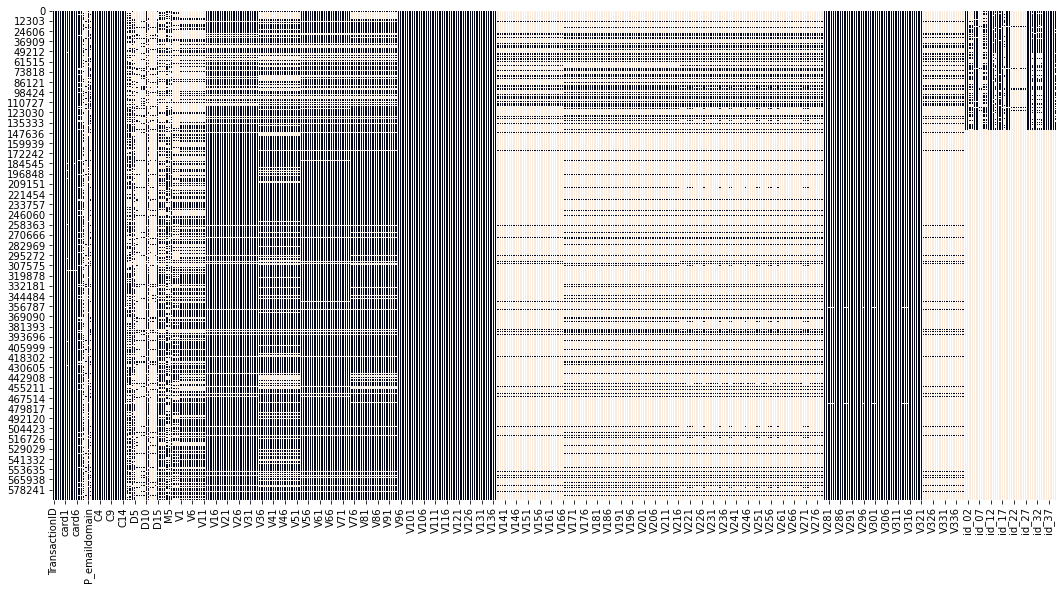

In [13]:
#plotting missing values in the dataset
plt.figure(figsize=(18,9))
sns.heatmap(Data.isnull(), cbar= False)

In [16]:
#variables with missing values
variables_missingvalues = [var for var in Data.columns if Data[var].isnull().mean() > 0]
variables_missingvalues

['card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88',
 'V89

In [17]:
print(f' {Data.isnull().any().sum()} columns having missing values.')
null_cols_train = [col for col in Data.columns if Data[col].isnull().sum() / Data.shape[0] > 0.90]
null_cols_train
print("More than 90% null in train: " + str(len(null_cols_train)))
print(null_cols_train)

 414 columns having missing values.
More than 90% null in train: 12
['dist2', 'D7', 'id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']


In [18]:
#checking duplicated rows
duplicateRows = Data[Data.duplicated()]
print(duplicateRows)

Empty DataFrame
Columns: [TransactionID, isFraud, TransactionDT, TransactionAmt, ProductCD, card1, card2, card3, card4, card5, card6, addr1, addr2, dist1, dist2, P_emaildomain, R_emaildomain, C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, C11, C12, C13, C14, D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, D11, D12, D13, D14, D15, M1, M2, M3, M4, M5, M6, M7, M8, M9, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, V29, V30, V31, V32, V33, V34, V35, V36, V37, V38, V39, V40, V41, V42, V43, V44, V45, ...]
Index: []

[0 rows x 434 columns]


In [19]:
#checking column with zero variance
col_Zvar = [i for i in Data.columns if Data[i].nunique() == 1]
print(" %d columns  with zero variance" % len(col_Zvar))

 0 columns  with zero variance


In [20]:
#checking categorical variables before feature engineering
cat_variables = list(Data.select_dtypes(include=['object']).columns)
cat_variables

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_15',
 'id_16',
 'id_23',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo']

Analysis of each attributes for gaining insights and feature engineering.

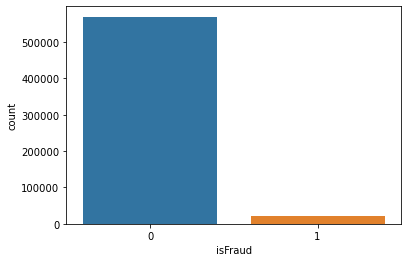

3.5 % are fraud transactions
96.5 % are legitimate transactions


0    569877
1     20663
Name: isFraud, dtype: int64

In [21]:
#checking target variable--(dataset imbalance)
sns.countplot(Data['isFraud'])
plt.show()
print(np.round(Data[Data['isFraud']==1].shape[0]/Data.shape[0]*100,2),'% are fraud transactions')
print(np.round(Data[Data['isFraud']==0].shape[0]/Data.shape[0]*100,2),'% are legitimate transactions')
Data['isFraud'].value_counts()

Most of the transactions in this dataset are non-fraud cases. If we use this dataset as the base for our predictive models and analysis, we might get a lot of errors and our algorithms will probably overfit.Hence, Resampling the dataset is agood option.

lets do the analysis on TransactionAmt distribution

In [22]:
print(pd.concat([Data[Data['isFraud'] == 1]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index(), 
                 Data[Data['isFraud'] == 0]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index()],
                axis=1, keys=['Fraud', "Legitimate"]))

  Fraud                Legitimate               
  index TransactionAmt      index TransactionAmt
0  0.01       6.739453       0.01       9.511875
1  0.10      18.937500       0.10      26.312500
2  0.25      35.031250       0.25      43.968750
3  0.50      75.000000       0.50      68.500000
4  0.75     161.000000       0.75     120.000000
5  0.90     335.000000       0.90     267.100000
6  0.99     994.000000       0.99    1104.000000


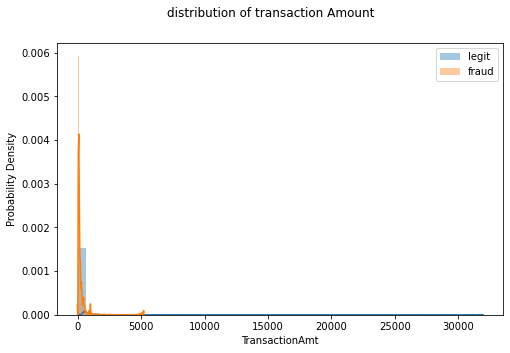

In [23]:
plt.figure(figsize=(8,5))
sns.distplot(Data[Data['isFraud']==0]['TransactionAmt'])
sns.distplot(Data[Data['isFraud']==1]['TransactionAmt'])
# plt.xticks(np.arange(0, 6500, 500))
plt.ylabel('Probability Density')
plt.legend(['legit','fraud'])
plt.suptitle('distribution of transaction Amount ' , fontsize=12)
plt.show()

TransactionAmt distribution is  skewed.we will do log  transformation for better visualization.

In [24]:
#lets create a new feature by taking logvalue of amount
Data['LogAmt'] = np.log(Data['TransactionAmt'])

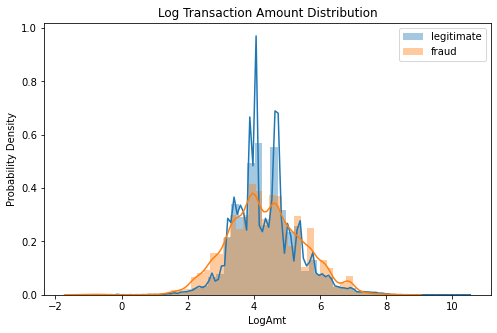

In [25]:
#log plot of TransactionAmt
plt.figure(figsize=(8,5))
sns.distplot(Data[Data['isFraud']==0]['LogAmt'])
sns.distplot(Data[Data['isFraud']==1]['LogAmt'])
# plt.xticks(np.arange(0, 6500, 500))
plt.ylabel('Probability Density')
plt.legend(['legitimate','fraud'])
plt.title('Log Transaction Amount Distribution' , fontsize=12)
plt.show()

 LogTransactionAmt that is larger than 6 and smaller than 3 have higher probability density being fraudulent.

In [26]:
#exploring transactionDT(in seconds)
#lets do some calculations of TransactionDT(timedelta)

period = (Data['TransactionDT'].max() - Data['TransactionDT'].min())/(3600*24)
print('period of data is {:.2f} days'.format(period))

period of data is 182.00 days


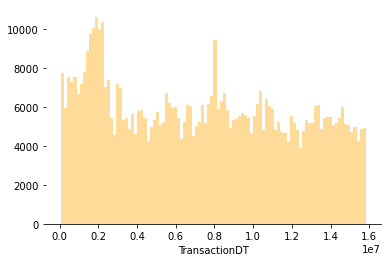

In [27]:
sns.distplot(Data['TransactionDT'],kde=False,bins= 100,color='orange')
sns.despine(left=True)

In [28]:
Data['day'] = (Data['TransactionDT']//(3600*24))%7

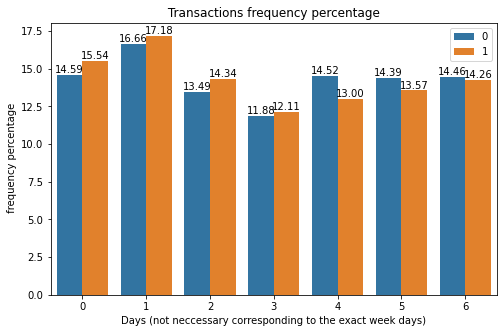

In [31]:
day = Data.groupby('isFraud')['day'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('day')
plt.figure(figsize=(8,5))
barplot = sns.barplot(x="day", y="percentage", hue="isFraud", data=day)
plt.legend()
plt.ylabel(' frequency percentage')
plt.xlabel('Days (not neccessary corresponding to the exact week days)')
plt.title(' Transactions frequency percentage ')
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
plt.show()

In [32]:
Data['Hour'] = (Data['TransactionDT']//(3600))%24

In [33]:
hour = (Data.groupby(['isFraud'])['Hour']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('Hour'))

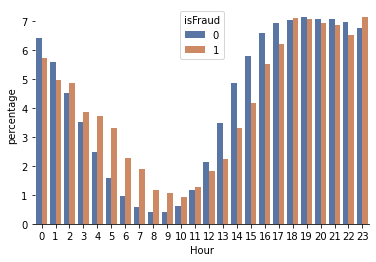

In [34]:
sns.barplot(x="Hour", y="percentage", hue="isFraud",palette="deep", data=hour)
sns.despine(left=True)

Around 2am-10am(time is not exact ) percentage of fraud transaction is higher than legitimate.

In [35]:
def interval_time(Hour):  
    
    if Hour<= 2:
        return "Night(21-2)"
    
    elif Hour<= 7:
        return "Early-Morning(3-7)"
    
    elif Hour<= 11:
        return "Morning(8-11)"
    
    elif Hour<= 16:
        return "Mid-Day(12-16)"
    
    elif Hour<= 20:
        return "Evening(17-20)"
    
    elif Hour <= 24:
        return "Night(21-2)"

In [36]:
Data['interval_time'] = Data['Hour'].apply(interval_time)

In [37]:
int_tim = pd.DataFrame((Data.groupby(['isFraud'])['interval_time']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('interval_time')))

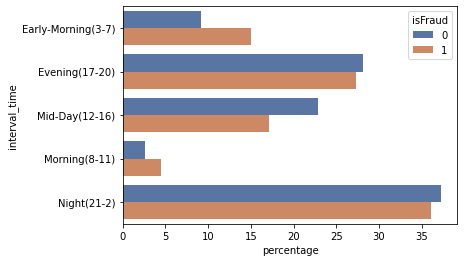

In [38]:
sns.barplot(y="interval_time", x="percentage", hue="isFraud",palette="deep", data=int_tim)

percentage of fraud transaction are more during early morning--morning (3am to 11am)

In [39]:
#test-train split (splitting data 80% train and 20% test)
Data['TransactionDT'].sort_values(ascending = True)
train_original = Data[:472432]
test_original= Data [472432:]

Text(0.5, 1.0, 'Amount vs timedelta by isFraud in test')

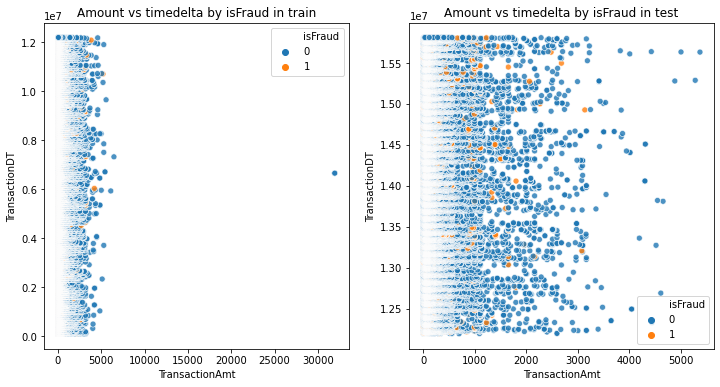

In [40]:
#TransactionDT & TransactionAmt
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
g1 = sns.scatterplot(x="TransactionAmt",y="TransactionDT",hue="isFraud", data=train_original, alpha=0.8, hue_order=[0,1])
plt.title('Amount vs timedelta by isFraud in train')
plt.subplot(1,2,2)
g1 = sns.scatterplot(x="TransactionAmt",y="TransactionDT",hue="isFraud", data=test_original, alpha=0.8, hue_order=[0,1])
plt.title('Amount vs timedelta by isFraud in test')

In [41]:
#Checking outliers
Q1 = train_original.quantile(0.25)
Q3 = train_original.quantile(0.75)
IQR = Q3 - Q1
TransactionAmt_IQR = IQR[3]
TransactionAmt_Q1 = Q1[3]
TransactionAmt_Q3 = Q3[3]
print(' %d  outliers lower than Q1 - 3*IQR' %len(train_original['TransactionAmt']
[train_original['TransactionAmt'] < (TransactionAmt_Q1 - 3 * TransactionAmt_IQR)]))

print(' %d  outliers higher than Q3 + 3*IQR' % len(train_original['TransactionAmt']
[train_original['TransactionAmt'] > (TransactionAmt_Q3 + 3 * TransactionAmt_IQR)]))

 0  outliers lower than Q1 - 3*IQR
 29031  outliers higher than Q3 + 3*IQR


There are outliers in train data.

lets explore column ProductCD(product code)

In [42]:
Data['ProductCD'].value_counts()

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

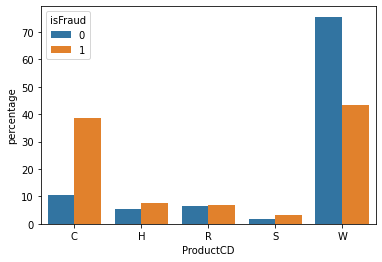

In [43]:
plt.figure(figsize=(6,4))
product= (Data.groupby(['isFraud'])['ProductCD']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('ProductCD'))
sns.barplot(x="ProductCD", y="percentage", hue="isFraud", data=product)

The transaction involving product C is having  high chance (that is 40% ) to be fraud.In H,R,S also there is a higher fraud percent compared to legitimate percent.Legitimate transaction percent is more for product w.

In [44]:
#lets explore the cards (card1,card2,card3,card4,card5,card6) 
card_list = pd.DataFrame(Data[['card1', 'card2', 'card3', 'card4', 'card5', 'card6']])
total_missing = card_list.isnull().sum().sort_values(ascending = False)
percent_missing = (card_list.isnull().sum()/card_list.isnull().count()*100)
datatype = card_list.dtypes
unique = card_list.nunique()
summary_card = pd.concat([total_missing, percent_missing,datatype,unique], axis=1, keys=['Total_missing', 'Percent_missing','datatype','unique'])
summary_card

Total_missing  Percent_missing datatype  unique
card2           8933         1.512683  float16     500
card5           4259         0.721204  float16     119
card4           1577         0.267044   object       4
card6           1571         0.266028   object       4
card3           1565         0.265012  float16     114
card1              0         0.000000    int16   13553

In [45]:
for i in range(1, 7):
    print(Data['card' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')

7919     0.025285
9500     0.023981
15885    0.017545
17188    0.017516
15066    0.013454
Name: card1, dtype: float64


321.0    0.082865
111.0    0.076525
555.0    0.071113
490.0    0.064593
583.0    0.036920
Name: card2, dtype: float64


150.0    0.882729
185.0    0.095414
106.0    0.002660
NaN      0.002650
146.0    0.002120
Name: card3, dtype: float64


visa                0.651551
mastercard          0.320414
american express    0.014102
discover            0.011263
NaN                 0.002670
Name: card4, dtype: float64


226.0    0.502161
224.0    0.138031
166.0    0.096759
102.0    0.049285
117.0    0.043928
Name: card5, dtype: float64


debit              0.744976
credit             0.252288
NaN                0.002660
debit or credit    0.000051
charge card        0.000025
Name: card6, dtype: float64




Card 1 and Card 2 has a large distribution of values.

Text(0.5, 1.0, 'Disctribution of Card 1')

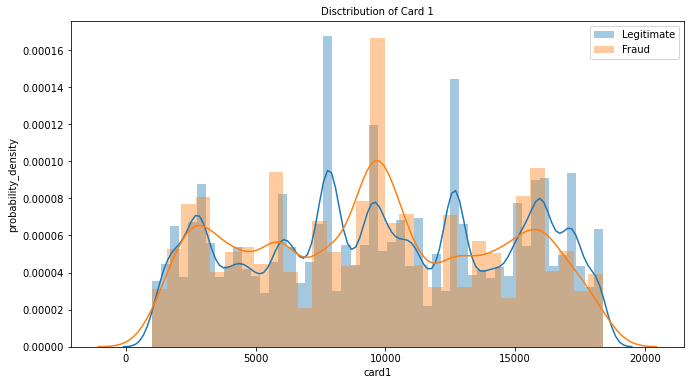

In [46]:
#card1
plt.figure(figsize=(11,6))
sns.distplot(Data[(Data['isFraud']==0) & (~Data['card1'].isnull())]['card1'])
sns.distplot(Data[(Data['isFraud']==1) & (~Data['card1'].isnull())]['card1'])
plt.legend(['Legitimate','Fraud'])
plt.ylabel('probability_density')
plt.title('Disctribution of Card 1' , fontsize=10)

Text(0.5, 1.0, 'Disctribution of Card 2')

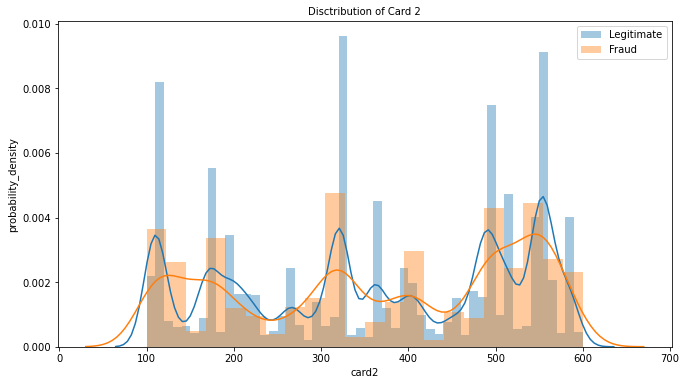

In [47]:
#card2
plt.figure(figsize=(11,6))
sns.distplot(Data[(Data['isFraud']==0) & (~Data['card2'].isnull())]['card2'])
sns.distplot(Data[(Data['isFraud']==1) & (~Data['card2'].isnull())]['card2'])
plt.legend(['Legitimate','Fraud'])
plt.ylabel('probability_density')
plt.title('Disctribution of Card 2' , fontsize=10)

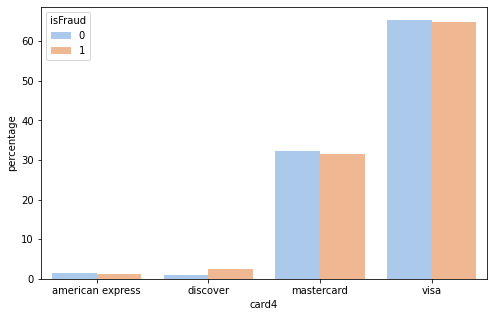

In [48]:
#card4
plt.figure(figsize=(8,5))
card4 = (Data[~Data['card4'].isnull()].groupby(['isFraud'])['card4'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('card4'))
sns.barplot(x="card4", y="percentage", hue="isFraud", data=card4, palette = 'pastel')
plt.show()

In [49]:
#replacing missing values with mode
Data.card4.fillna("visa", inplace=True)

Visa card is having most transactions.most fraudulent transaction happened in visa card and then master card.

Text(0.5, 1.0, 'Disctribution of Card 2')

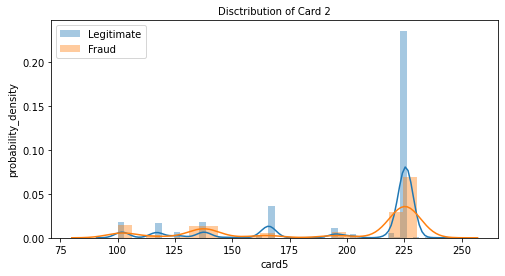

In [50]:
#card5
plt.figure(figsize=(8,4))
sns.distplot(Data[(Data['isFraud']==0) & (~Data['card5'].isnull())]['card5'])
sns.distplot(Data[(Data['isFraud']==1) & (~Data['card5'].isnull())]['card5'])
plt.legend(['Legitimate','Fraud'])
plt.ylabel('probability_density')
plt.title('Disctribution of Card 2' , fontsize=10)

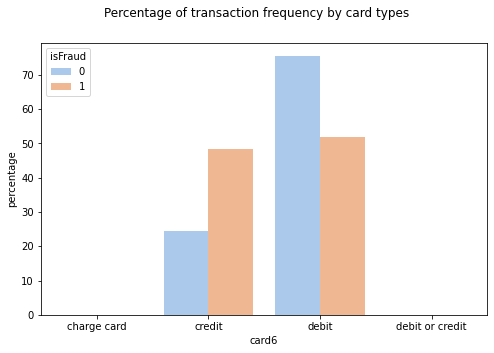

In [52]:
# card6
plt.figure(figsize=(8,5))
card6 = (Data[~Data['card6'].isnull()].groupby(['isFraud'])['card6'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('card6'))
sns.barplot(x="card6", y="percentage", hue="isFraud", data=card6, palette = 'pastel')
plt.suptitle('Percentage of transaction frequency by card types', fontsize=12)
plt.show()

credit card is having  higher percentage of fraud rate. Debit or credit and charge card are almost 0% in the dataset.

In [53]:
##replace debit or credit and charge card to debit(replacing rare values with mode)

Data.loc[Data['card6'].isin(['debit or credit', 'charge card']),'card6'] = 'debit'
Data.card6.fillna("debit", inplace=True)

In [54]:
#lets do log transformation of all numerical cards
Data['Logcard1'] = np.log(Data['card1'])
Data['Logcard2'] = np.log(Data['card2'])
Data['Logcard3'] = np.log(Data['card3'])
Data['Logcard5'] = np.log(Data['card5'])

In [55]:
#adress-addr1,addr2
##addr1-purchaser's billing region(zipcode),addr2-purchaser's billing country.

In [56]:
address = pd.DataFrame(Data[['addr1', 'addr2']])
total_missing = address.isnull().sum().sort_values(ascending = False)
percent_missing = (address.isnull().sum()/address.isnull().count()*100)
datatype = address.dtypes
unique = address.nunique()
summary_addr = pd.concat([total_missing, percent_missing,datatype,unique], axis=1, keys=['Total_missing', 'Percent_missing','datatype','unique'])
summary_addr

Total_missing  Percent_missing datatype  unique
addr2          65706        11.126427  float16      74
addr1          65706        11.126427  float16     332

In [57]:
Data['addr1'].value_counts()

299.0    46335
325.0    42751
204.0    42020
264.0    39870
330.0    26287
         ...  
462.0        1
128.0        1
481.0        1
120.0        1
340.0        1
Name: addr1, Length: 332, dtype: int64

In [58]:
Data.addr1.unique()

array([315., 325., 330., 476., 420., 272., 126., 337., 204.,  nan, 226.,
       170., 184., 264., 299., 441., 472., 251., 469., 191., 485., 122.,
       220., 205., 387., 181., 231., 436., 327., 343., 123., 502., 269.,
       158., 433., 143., 225., 492., 177., 512., 310., 308., 418., 494.,
       253., 428., 203., 110., 444., 498., 194., 536., 384., 324., 295.,
       448., 157., 171., 224., 491., 274., 432., 459., 106., 296., 254.,
       452., 347., 335., 305., 161., 221., 154., 130., 465., 451., 331.,
       511., 486., 312., 242., 131., 508., 332., 283., 216., 431., 391.,
       333., 496., 304., 167., 261., 399., 164., 142., 393., 258., 375.,
       483., 404., 482., 148., 218., 127., 403., 374., 477., 478., 241.,
       504., 453., 535., 100., 239., 152., 500., 356., 198., 162., 244.,
       520., 531., 401., 427., 352., 540., 456., 371., 409., 529., 505.,
       503., 346., 359., 499., 298., 190., 454., 172., 145., 493., 119.,
       521., 270., 395., 366., 348., 313., 338., 13

In [59]:
Data['addr2'].value_counts()

87.0    520481
60.0      3084
96.0       638
32.0        91
65.0        82
         ...  
55.0         1
79.0         1
49.0         1
50.0         1
70.0         1
Name: addr2, Length: 74, dtype: int64

In [60]:
Data.addr2.unique()

array([ 87.,  nan,  96.,  35.,  60.,  98.,  43.,  65.,  32.,  13.,  31.,
       101.,  24.,  16.,  15.,  19.,  71.,  59., 102.,  44.,  26.,  69.,
        47.,  78.,  88.,  66.,  72.,  22.,  57.,  25.,  17.,  30.,  29.,
        21.,  14.,  49.,  83.,  75.,  34.,  86.,  48.,  68.,  23.,  70.,
        62.,  54.,  50.,  52.,  39.,  76.,  10.,  73.,  97.,  63.,  27.,
        28.,  38.,  74.,  77.,  92.,  79.,  84.,  82.,  40.,  36.,  46.,
        18.,  20.,  89.,  61.,  94., 100.,  55.,  51.,  93.],
      dtype=float16)

In [61]:
# replacing rear values with mode in addr1 and addr2.
Data.loc[Data.addr1.isin(Data.addr1.value_counts()[Data.addr1.value_counts() <= 5000 ].index), 'addr1'] = "299.0"

Data.loc[Data.addr2.isin(Data.addr2.value_counts()[Data.addr2.value_counts() <= 50 ].index), 'addr2'] = "87.0"

Text(0.5, 0.98, 'Disctribution of addr1')

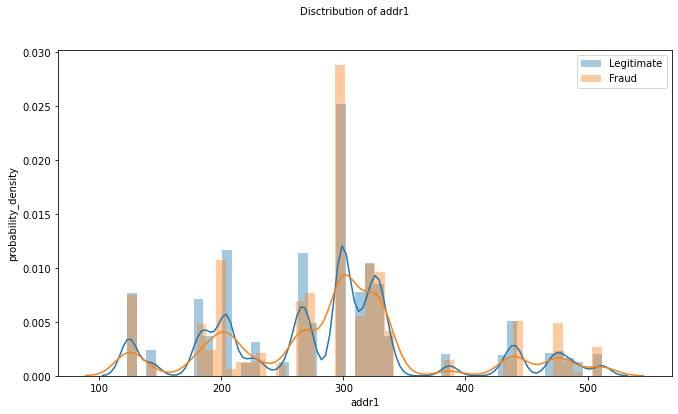

In [62]:
plt.figure(figsize=(11,6))
sns.distplot(Data[(Data['isFraud']==0) & (~Data['addr1'].isnull())]['addr1'])
sns.distplot(Data[(Data['isFraud']==1) & (~Data['addr1'].isnull())]['addr1'])
plt.legend(['Legitimate','Fraud'])
plt.ylabel('probability_density')
plt.suptitle('Disctribution of addr1' , fontsize=10)

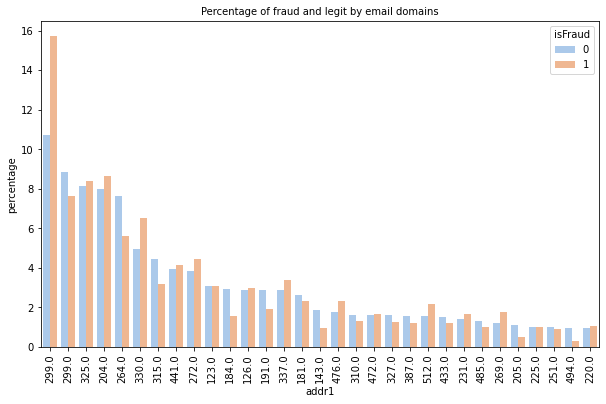

In [63]:
plt.figure(figsize=(10,6))
addr1 = (Data[~Data['addr1'].isnull()].groupby(['isFraud'])['addr1']\
         .value_counts(normalize=True).rename('percentage')\
         .mul(100).reset_index())
sns.barplot(x="addr1", y="percentage", hue="isFraud", data=addr1, palette = 'pastel')
plt.xticks(rotation=90)
plt.title('Percentage of fraud and legit by email domains', fontsize=10)
plt.show()

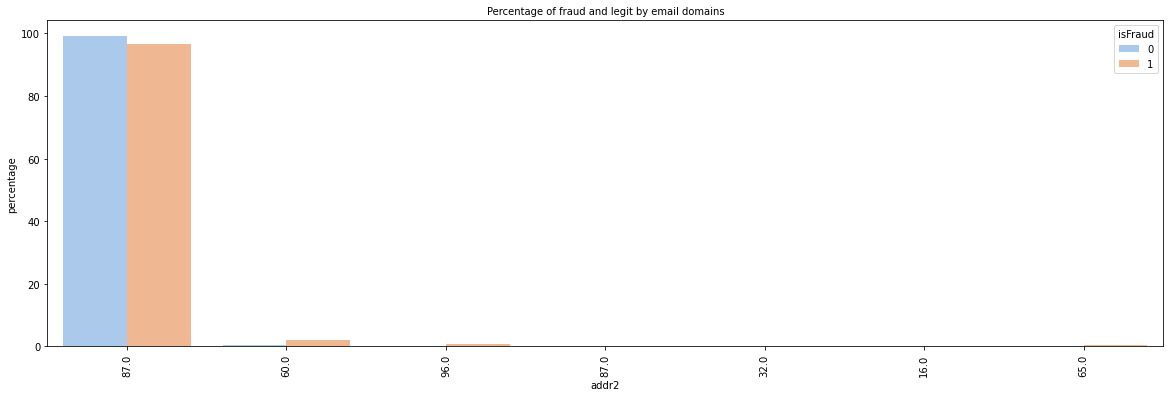

In [64]:
plt.figure(figsize=(20,6))
addr1 = (Data[~Data['addr2'].isnull()].groupby(['isFraud'])['addr2']\
         .value_counts(normalize=True).rename('percentage')\
         .mul(100).reset_index())
sns.barplot(x="addr2", y="percentage", hue="isFraud", data=addr1, palette = 'pastel')
plt.xticks(rotation=90)
plt.title('Percentage of fraud and legit by email domains', fontsize=10)
plt.show()

Highest fraud transactions are happening in billing region 299 and billing country 87.

In [65]:
#distance-dist1
distance = pd.DataFrame(Data[['dist1']])
total_missing = distance.isnull().sum().sort_values(ascending = False)
percent_missing = (distance.isnull().sum()/distance.isnull().count()*100)
datatype = distance.dtypes
unique = distance.nunique()
summary_addr = pd.concat([total_missing, percent_missing,datatype,unique], axis=1, keys=['Total_missing', 'Percent_missing','datatype','unique'])
summary_addr

Total_missing  Percent_missing datatype  unique
dist1         352271        59.652352  float16    2412

In [66]:
print("distance: ")
print(Data[['dist1' ]].quantile([0.01, .025, .1, .25, .5, .75, .975, .99]))

distance: 
        dist1
0.010     0.0
0.025     0.0
0.100     1.0
0.250     3.0
0.500     8.0
0.750    24.0
0.975  1284.0
0.990  2040.0


Text(0.5, 1.0, 'dist1')

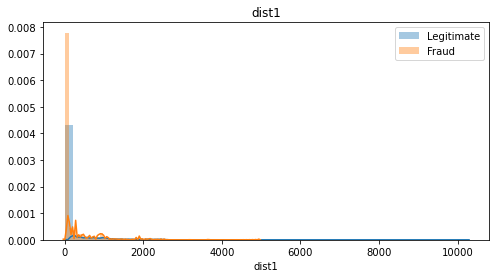

In [67]:
#dist1
plt.figure(figsize=(8,4))
sns.distplot(Data[(Data['isFraud']==0) & (~Data['dist1'].isnull())]['dist1'])
sns.distplot(Data[(Data['isFraud']==1) & (~Data['dist1'].isnull())]['dist1'])
plt.legend(['Legitimate','Fraud'])
plt.title('dist1')

In [68]:
## replacing missing values with an arbitary value
Data['dist1'] = Data['dist1'].fillna(-10)
Data['dist1'] = Data['dist1'].fillna(-10)

In [69]:
#Analysis of email domains-(P_emaildomain,R_emaildomain)
Data['P_emaildomain'].value_counts()

gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
hotmail.es             305
windstream.net         305
roadrunner.com         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
netzero.com            230
t

In [70]:
#R_emaildomain
Data['R_emaildomain'].value_counts()

gmail.com           57147
hotmail.com         27509
anonymous.com       20529
yahoo.com           11842
aol.com              3701
outlook.com          2507
comcast.net          1812
yahoo.com.mx         1508
icloud.com           1398
msn.com               852
live.com              762
live.com.mx           754
verizon.net           620
me.com                556
sbcglobal.net         552
cox.net               459
outlook.es            433
att.net               430
bellsouth.net         422
hotmail.fr            293
hotmail.es            292
web.de                237
mac.com               218
ymail.com             207
prodigy.net.mx        207
optonline.net         187
gmx.de                147
yahoo.fr              137
charter.net           127
mail.com              122
hotmail.co.uk         105
gmail                  95
earthlink.net          79
yahoo.de               75
rocketmail.com         69
embarqmail.com         68
scranton.edu           63
yahoo.es               57
live.fr     

In [71]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum',
          'scranton.edu': 'other', 'netzero.net': 'other',
          'optonline.net': 'other', 'comcast.net': 'other', 
          'cfl.rr.com': 'other', 'sc.rr.com': 'other',
          'suddenlink.net': 'other', 'windstream.net': 'other',
          'gmx.de': 'other', 'earthlink.net': 'other', 
          'servicios-ta.com': 'other', 'bellsouth.net': 'other', 
          'web.de': 'other', 'mail.com': 'other',
          'cableone.net': 'other', 'roadrunner.com': 'other', 
          'protonmail.com': 'other', 'anonymous.com': 'other',
          'juno.com': 'other', 'ptd.net': 'other',
          'netzero.com': 'other', 'cox.net': 'other', 
          'hotmail.co.uk': 'microsoft', 
          'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 
          'live.com': 'microsoft', 'aim.com': 'aol',
          'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 
          'hotmail.com': 'microsoft',  
          'hotmail.fr': 'microsoft',
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 
          'yahoo.de': 'yahoo', 
          'live.fr': 'microsoft', 'verizon.net': 'yahoo', 
          'msn.com': 'microsoft', 'q.com': 'centurylink',
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 
           'rocketmail.com': 'yahoo', 
          'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 
          'embarqmail.com': 'centurylink', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo',
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft',
           'aol.com': 'aol', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

In [72]:
for c in ['P_emaildomain', 'R_emaildomain']:
    Data[c + '_bin'] = Data[c].map(emails)
    Data[c + '_suffix'] = Data[c].map(lambda x: str(x).split('.')[-1])
    Data[c + '_suffix']= Data[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

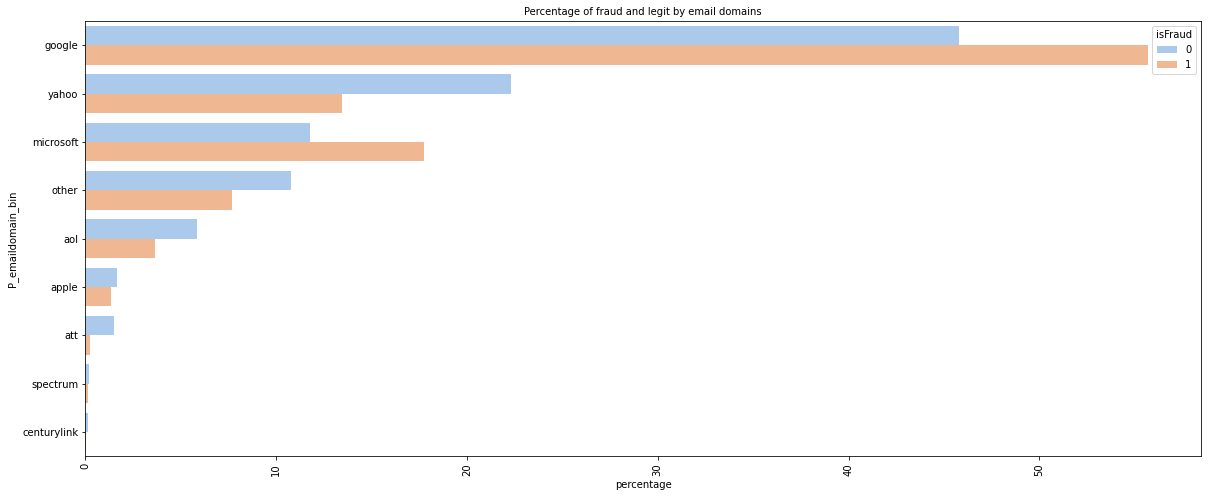

In [73]:
plt.figure(figsize=(20,8))
train_P_email = (Data[~Data['P_emaildomain_bin'].isnull()].groupby(['isFraud'])['P_emaildomain_bin'].value_counts(normalize=True).rename('percentage').mul(100).reset_index())
sns.barplot(y="P_emaildomain_bin", x="percentage", hue="isFraud", data=train_P_email, palette = 'pastel')
plt.xticks(rotation=90)
plt.title('Percentage of fraud and legit by email domains', fontsize=10)
plt.show()

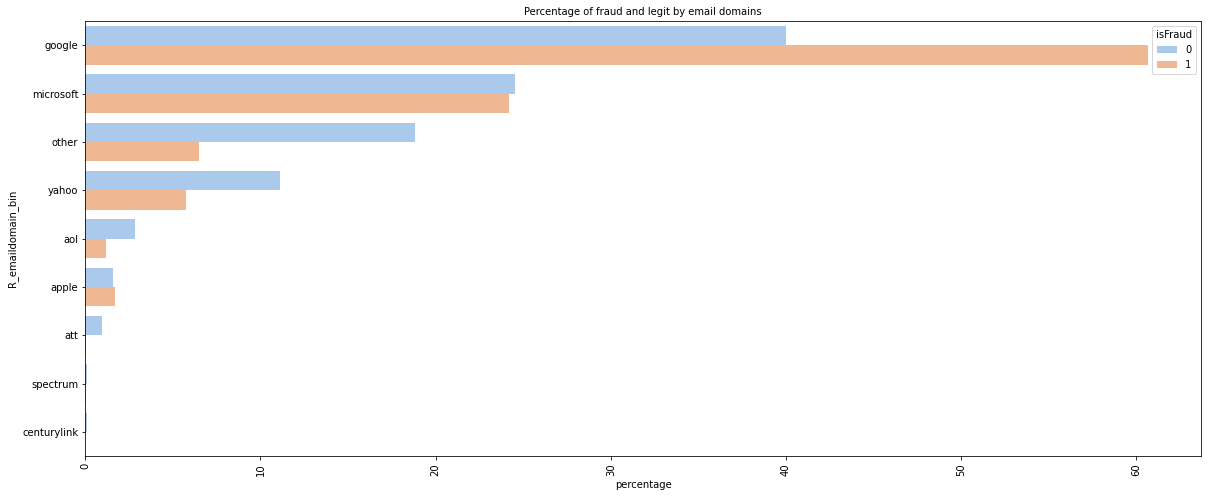

In [74]:
plt.figure(figsize=(20,8))
R_email = (Data[~Data['R_emaildomain_bin'].isnull()].groupby(['isFraud'])['R_emaildomain_bin'].value_counts(normalize=True).rename('percentage').mul(100).reset_index())
sns.barplot(y="R_emaildomain_bin", x="percentage", hue="isFraud", data=R_email, palette = 'pastel')
plt.xticks(rotation=90)
plt.title('Percentage of fraud and legit by email domains', fontsize=10)
plt.show()

Google is the most frequent email domain in both columns.It is the most commonly used email domain by frauds.

M1-M9(names on cards and adresses etc)

In [75]:
for i in range(1, 10):
    print(Data['M' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')

T      0.540886
NaN    0.459071
F      0.000042
Name: M1, dtype: float64


T      0.483402
NaN    0.459071
F      0.057527
Name: M2, dtype: float64


NaN    0.459071
T      0.426273
F      0.114656
Name: M3, dtype: float64


NaN    0.476588
M0     0.332585
M2     0.101373
M1     0.089454
Name: M4, dtype: float64


NaN    0.593494
F      0.224356
T      0.182150
Name: M5, dtype: float64


F      0.385843
T      0.327368
NaN    0.286788
Name: M6, dtype: float64


NaN    0.586353
F      0.357933
T      0.055713
Name: M7, dtype: float64


NaN    0.586331
F      0.262897
T      0.150772
Name: M8, dtype: float64


NaN    0.586331
T      0.348251
F      0.065418
Name: M9, dtype: float64




In [76]:
#There are a lot of missing values in M1-M9. Replacing missing values with 'Miss'
m_feat = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
for col in m_feat:
    Data[col].fillna('Miss', inplace=True)

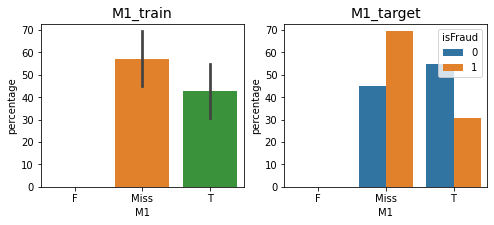

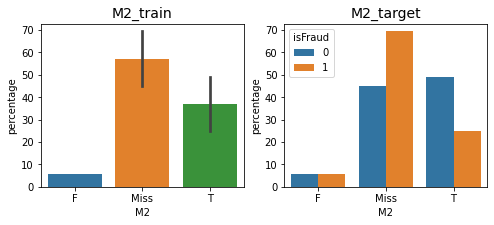

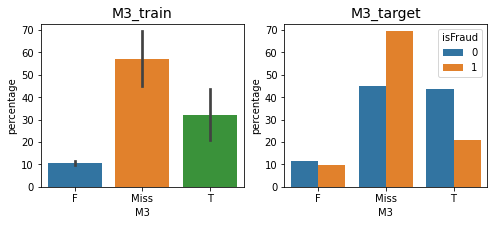

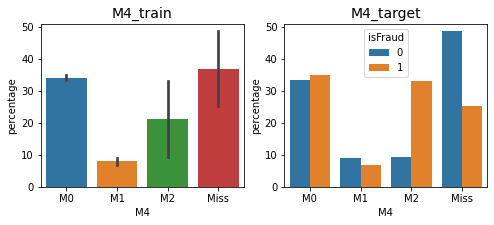

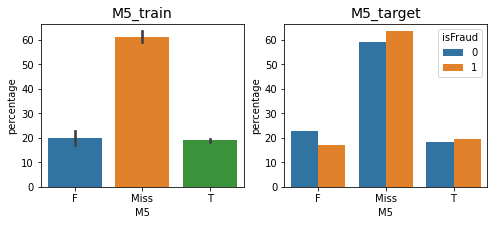

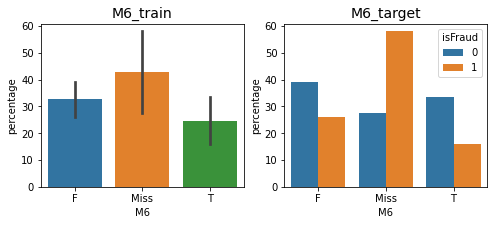

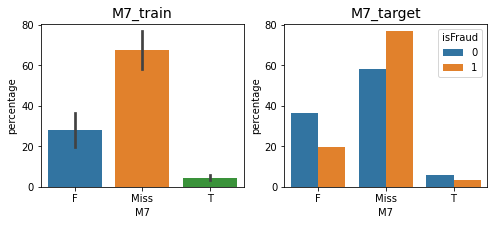

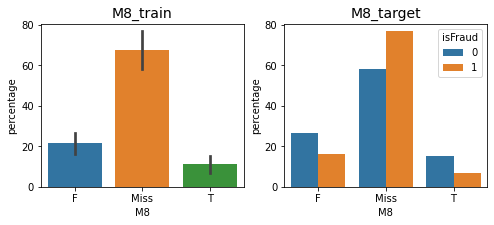

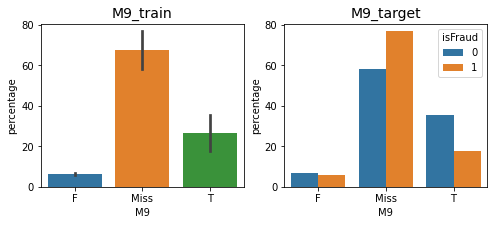

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
m1_grouped = (Data.groupby(['isFraud'])['M1']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M1'))
sns.barplot(x="M1", ax=ax[0],y="percentage", data=m1_grouped)
ax[0].set_title('M1_train', fontsize=14)
sns.barplot(x="M1",ax=ax[1], y="percentage", hue="isFraud", data=m1_grouped)
ax[1].set_title('M1_target', fontsize=14)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,3))
m2_grouped = (Data.groupby(['isFraud'])['M2']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M2'))
sns.barplot(x="M2", ax=ax[0],y="percentage", data=m2_grouped)
ax[0].set_title('M2_train', fontsize=14)
sns.barplot(x="M2",ax=ax[1], y="percentage", hue="isFraud", data=m2_grouped)
ax[1].set_title('M2_target', fontsize=14)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,3))
m3_grouped = (Data.groupby(['isFraud'])['M3']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M3'))
sns.barplot(x="M3", ax=ax[0],y="percentage", data=m3_grouped)
ax[0].set_title('M3_train', fontsize=14)
sns.barplot(x="M3",ax=ax[1], y="percentage", hue="isFraud", data=m3_grouped)
ax[1].set_title('M3_target', fontsize=14)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,3))
m4_grouped = (Data.groupby(['isFraud'])['M4']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M4'))
sns.barplot(x="M4", ax=ax[0],y="percentage", data=m4_grouped)
ax[0].set_title('M4_train', fontsize=14)
sns.barplot(x="M4",ax=ax[1], y="percentage", hue="isFraud", data=m4_grouped)
ax[1].set_title('M4_target', fontsize=14)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,3))
m5_grouped = (Data.groupby(['isFraud'])['M5']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M5'))
sns.barplot(x="M5", ax=ax[0],y="percentage", data=m5_grouped)
ax[0].set_title('M5_train', fontsize=14)
sns.barplot(x="M5",ax=ax[1], y="percentage", hue="isFraud", data=m5_grouped)
ax[1].set_title('M5_target', fontsize=14)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,3))
m6_grouped = (Data.groupby(['isFraud'])['M6']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M6'))
sns.barplot(x="M6", ax=ax[0],y="percentage", data=m6_grouped)
ax[0].set_title('M6_train', fontsize=14)
sns.barplot(x="M6",ax=ax[1], y="percentage", hue="isFraud", data=m6_grouped)
ax[1].set_title('M6_target', fontsize=14)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,3))
m7_grouped = (Data.groupby(['isFraud'])['M7']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M7'))
sns.barplot(x="M7", ax=ax[0],y="percentage", data=m7_grouped)
ax[0].set_title('M7_train', fontsize=14)
sns.barplot(x="M7",ax=ax[1], y="percentage", hue="isFraud", data=m7_grouped)
ax[1].set_title('M7_target', fontsize=14)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,3))
m8_grouped = (Data.groupby(['isFraud'])['M8']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M8'))
sns.barplot(x="M8", ax=ax[0],y="percentage", data=m8_grouped)
ax[0].set_title('M8_train', fontsize=14)
sns.barplot(x="M8",ax=ax[1], y="percentage", hue="isFraud", data=m8_grouped)
ax[1].set_title('M8_target', fontsize=14)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8,3))
m9_grouped = (Data.groupby(['isFraud'])['M9']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('M9'))
sns.barplot(x="M9", ax=ax[0],y="percentage", data=m9_grouped)
ax[0].set_title('M9_train', fontsize=14)
sns.barplot(x="M9",ax=ax[1], y="percentage", hue="isFraud", data=m9_grouped)
ax[1].set_title('M9_target', fontsize=14)
plt.show()

ID(ID1-ID38)

In [78]:
# EXPLORING ID COLUMNS
###All columns have missing values above 75%

for i in range(1, 10):
    print(Data['id_0' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')
    
for i in range(10, 39):
    print(Data['id_' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')

 NaN     0.755761
-5.0     0.139144
 0.0     0.033114
-10.0    0.019062
-20.0    0.018984
Name: id_01, dtype: float64


NaN       0.761452
1102.0    0.000019
696.0     0.000017
1116.0    0.000015
1120.0    0.000015
Name: id_02, dtype: float64


NaN    0.887689
0.0    0.108211
1.0    0.001461
3.0    0.001131
2.0    0.000713
Name: id_03, dtype: float64


 NaN    0.887689
 0.0    0.111320
-5.0    0.000224
-6.0    0.000166
-8.0    0.000108
Name: id_04, dtype: float64


NaN    0.768238
0.0    0.157048
1.0    0.014043
2.0    0.008360
3.0    0.006526
Name: id_05, dtype: float64


 NaN    0.768238
 0.0    0.154647
-1.0    0.007937
-5.0    0.006518
-6.0    0.005515
Name: id_06, dtype: float64


NaN     0.991271
0.0     0.000693
16.0    0.000415
14.0    0.000386
12.0    0.000352
Name: id_07, dtype: float64


 NaN      0.991271
-100.0    0.000847
 0.0      0.000442
-34.0     0.000435
-33.0     0.000354
Name: id_08, dtype: float64


NaN    0.873123
0.0    0.119176
1.0    0.002736
3.0    0.001636
2

In [79]:
#All the id columns having missing values 75% and above.
#lets take a closer look(id_30,id_31-- contains versions and id_33 contains resolution)
Data['id_30'].value_counts().head()  

Windows 10     21155
Windows 7      13110
iOS 11.2.1      3722
iOS 11.1.2      3699
Android 7.0     2871
Name: id_30, dtype: int64

In [80]:
Data['id_31'].value_counts().head()  

chrome 63.0              22000
mobile safari 11.0       13423
mobile safari generic    11474
ie 11.0 for desktop       9030
safari generic            8195
Name: id_31, dtype: int64

In [81]:
Data['id_33'].value_counts().head()  

1920x1080    16874
1366x768      8605
1334x750      6447
2208x1242     4900
1440x900      4384
Name: id_33, dtype: int64

id_30,id_31 contains versions, id_33 contains resolution we will split these colums and will replace missing values.

In [82]:
Data['OS_id_30'] = Data['id_30'].str.split(' ', expand=True)[0]
Data['version_id_30'] = Data['id_30'].str.split(' ',expand=True)[1] 
Data['OS_id_30'].fillna('None', inplace=True) 
Data['version_id_30'].fillna('None', inplace=True) 
Data.drop('id_30', axis=1, inplace=True)

In [83]:
Data['browser_id_31'] = Data['id_31'].str.split(' ', expand=True)[0]
Data['version_id_31'] = Data['id_31'].str.split(' ', expand=True)[1] 
Data['browser_id_31'].fillna('None', inplace=True)
Data['version_id_31'].fillna('None', inplace=True) 
Data.drop('id_31', axis=1, inplace=True)

In [84]:
Data['screen_width'] = Data['id_33'].str.split('x', expand=True)[0] 
Data['screen_height'] = Data['id_33'].str.split('x', expand=True)[1]
Data['screen_width'].fillna(-1, inplace=True)
Data['screen_height'].fillna(-1, inplace=True)
Data.drop('id_33', axis=1, inplace=True)

In [85]:
Data['id_34'] = Data['id_34'].str.split(':', expand=True)[1] 
Data['id_34'].fillna(-2, inplace=True)
Data['id_23'] = Data['id_23'].str.split(':', expand=True)[1] 
Data['id_23'].fillna('None', inplace=True) 

In [86]:
#replacing missing values in numerical id columns with an arbitary value
id_num = ['id_13', 'id_14', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_24', 'id_25', 'id_26','id_32']

for col in id_num:
    Data[col].fillna(Data[col].min() - 100, inplace=True)

In [87]:
#replacing missing values in categorical id columns  with label  'none'.
to_fill_none = ['id_12','id_15', 'id_16', 'id_23','id_27', 'id_28', 'id_29', 'id_35', 'id_36', 'id_37', 'id_38']
for col in to_fill_none: 
    Data[col].fillna('None', inplace=True)

In [88]:
ID_features = Data[['id_01','id_02','id_03','id_04','id_05','id_06','id_09','id_10','id_11',
             'id_13','id_14','id_17','id_19','id_20','id_28','id_29','id_32',
             'id_34','id_35','id_36','id_37','id_38','isFraud']]

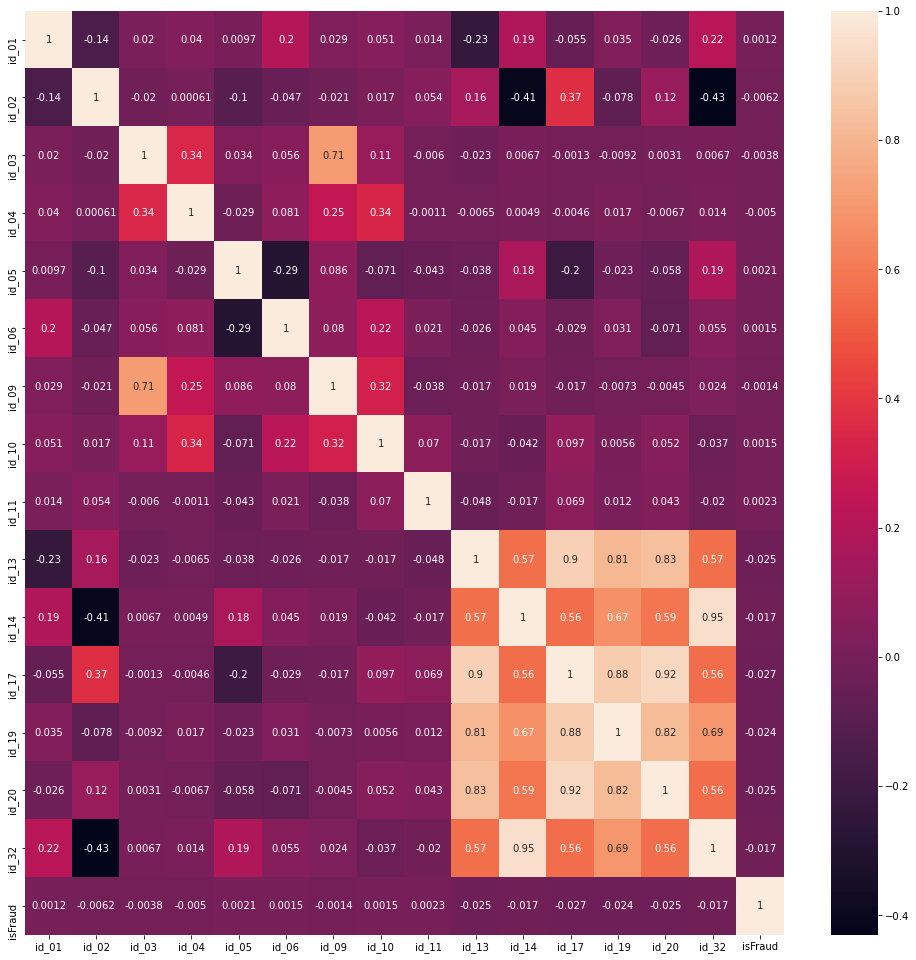

In [89]:
#Checking correlation between numerical ID columns
plt.figure(figsize=(17,17))
sns.heatmap(ID_features.corr(),annot=True)

some of the ID columns are highly correlated

Device Type

In [90]:
Data['DeviceType'].value_counts()

desktop    85165
mobile     55645
Name: DeviceType, dtype: int64

In [91]:
Data['DeviceType'].fillna('None', inplace=True)

Text(0.5, 1.0, 'Devicetype')

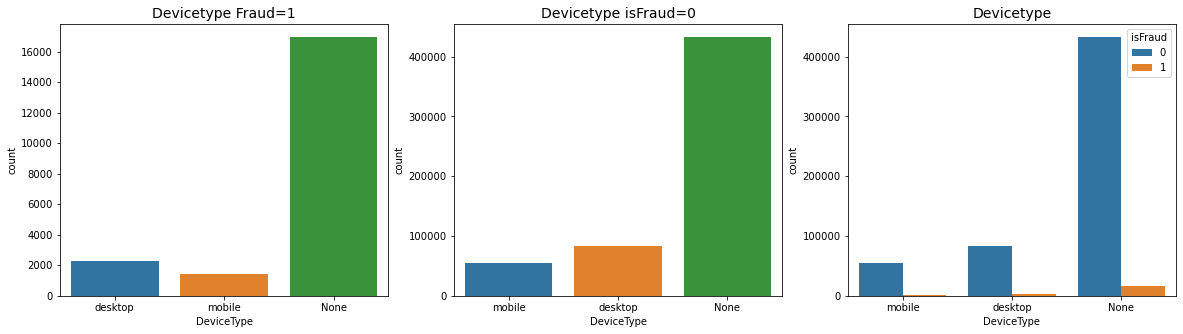

In [92]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
sns.countplot(x="DeviceType", ax=ax[0], data=Data.loc[Data['isFraud'] == 1])
ax[0].set_title('Devicetype Fraud=1', fontsize=14)
sns.countplot(x="DeviceType", ax=ax[1], data=Data.loc[Data['isFraud'] == 0])
ax[1].set_title('Devicetype isFraud=0', fontsize=14)
sns.countplot(x="DeviceType",ax=ax[2], hue = "isFraud", data=Data)
ax[2].set_title('Devicetype', fontsize=14)

Fraud transactions are more for desktop device type.

In [93]:
#DeviceInfo--contains device  name and versions.
Data['DeviceInfo'].value_counts().head(10)

Windows                  47722
iOS Device               19782
MacOS                    12573
Trident/7.0               7440
rv:11.0                   1901
rv:57.0                    962
SM-J700M Build/MMB29K      549
SM-G610M Build/MMB29K      461
SM-G531H Build/LMY48B      410
rv:59.0                    362
Name: DeviceInfo, dtype: int64

In [94]:
Data.DeviceInfo.unique()

array(['SAMSUNG SM-G892A Build/NRD90M', 'iOS Device', 'Windows', ...,
       'LDN-LX3 Build/HUAWEILDN-LX3', 'Z955A', 'LG-E975'], dtype=object)

Device_Info contains versions.Hence splitting  that column into 2 and will doing missing value imputation.

In [95]:
Data['device_name'] = Data['DeviceInfo'].str.split('/', expand=True)[0] 
Data['device_version'] = Data['DeviceInfo'].str.split('/', expand=True)[1]

Data.drop('DeviceInfo', axis=1, inplace=True)

Data['device_name'].fillna('None', inplace=True) 
Data['device_version'].fillna('None', inplace=True)

In [96]:
Data.loc[Data['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung' 
Data.loc[Data['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
Data.loc[Data['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung' 
Data.loc[Data['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
Data.loc[Data['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola' 
Data.loc[Data['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola' 
Data.loc[Data['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
Data.loc[Data['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV' 
Data.loc[Data['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei' 
Data.loc[Data['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
Data.loc[Data['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei' 
Data.loc[Data['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE' 
Data.loc[Data['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE' 
Data.loc[Data['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux' 
Data.loc[Data['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony' 
Data.loc[Data['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC' 
Data.loc[Data['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

In [97]:
#Replacing rear values with arbitary value -others
Data.loc[Data.device_name.isin(Data.device_name.value_counts()
        [Data.device_name.value_counts() < 200].index),
          'device_name'] = "Others"

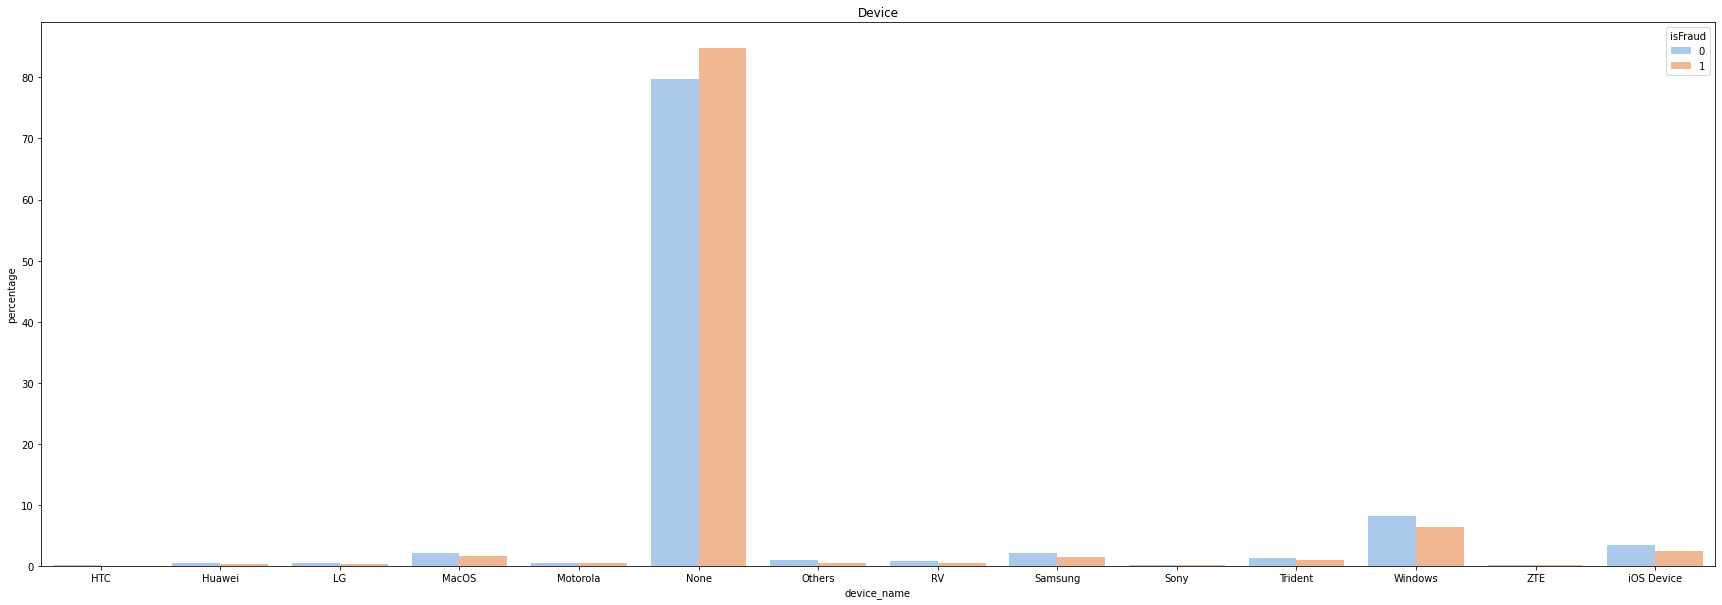

In [98]:
plt.figure(figsize=(30,10))
DeviceCorp = (Data[~Data['device_name'].isnull()].groupby(['isFraud'])['device_name'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('device_name'))
sns.barplot(x="device_name", y="percentage", hue="isFraud", data=DeviceCorp, palette = 'pastel')
plt.title('Device')
plt.show()

In [99]:
#Dfeatures
for i in range(1, 10):
    print(Data['D' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')
for i in range(10, 16):
    print(Data['D' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')    
    

0.0    0.474362
1.0    0.014621
2.0    0.008414
3.0    0.006696
4.0    0.006045
Name: D1, dtype: float64


NaN    0.475492
0.0    0.025610
1.0    0.011268
2.0    0.007542
3.0    0.006227
Name: D2, dtype: float64


NaN    0.445149
0.0    0.123775
1.0    0.035998
2.0    0.023350
7.0    0.022556
Name: D3, dtype: float64


NaN    0.286047
0.0    0.282066
1.0    0.009000
2.0    0.005732
3.0    0.004355
Name: D4, dtype: float64


NaN    0.524674
0.0    0.110707
1.0    0.025878
2.0    0.017347
7.0    0.016483
Name: D5, dtype: float64


NaN      0.876068
0.0      0.077526
1.0      0.002689
256.0    0.001516
2.0      0.001448
Name: D6, dtype: float64


NaN    0.934099
0.0    0.035789
1.0    0.002908
2.0    0.001690
3.0    0.001339
Name: D7, dtype: float64


NaN         0.873123
0.791504    0.002288
0.833496    0.002247
0.875000    0.002208
0.958496    0.002201
Name: D8, dtype: float64


NaN         0.873123
0.791504    0.009124
0.833496    0.008929
0.750000    0.008716
0.708496    0.008690
Name

/Users/neenu/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


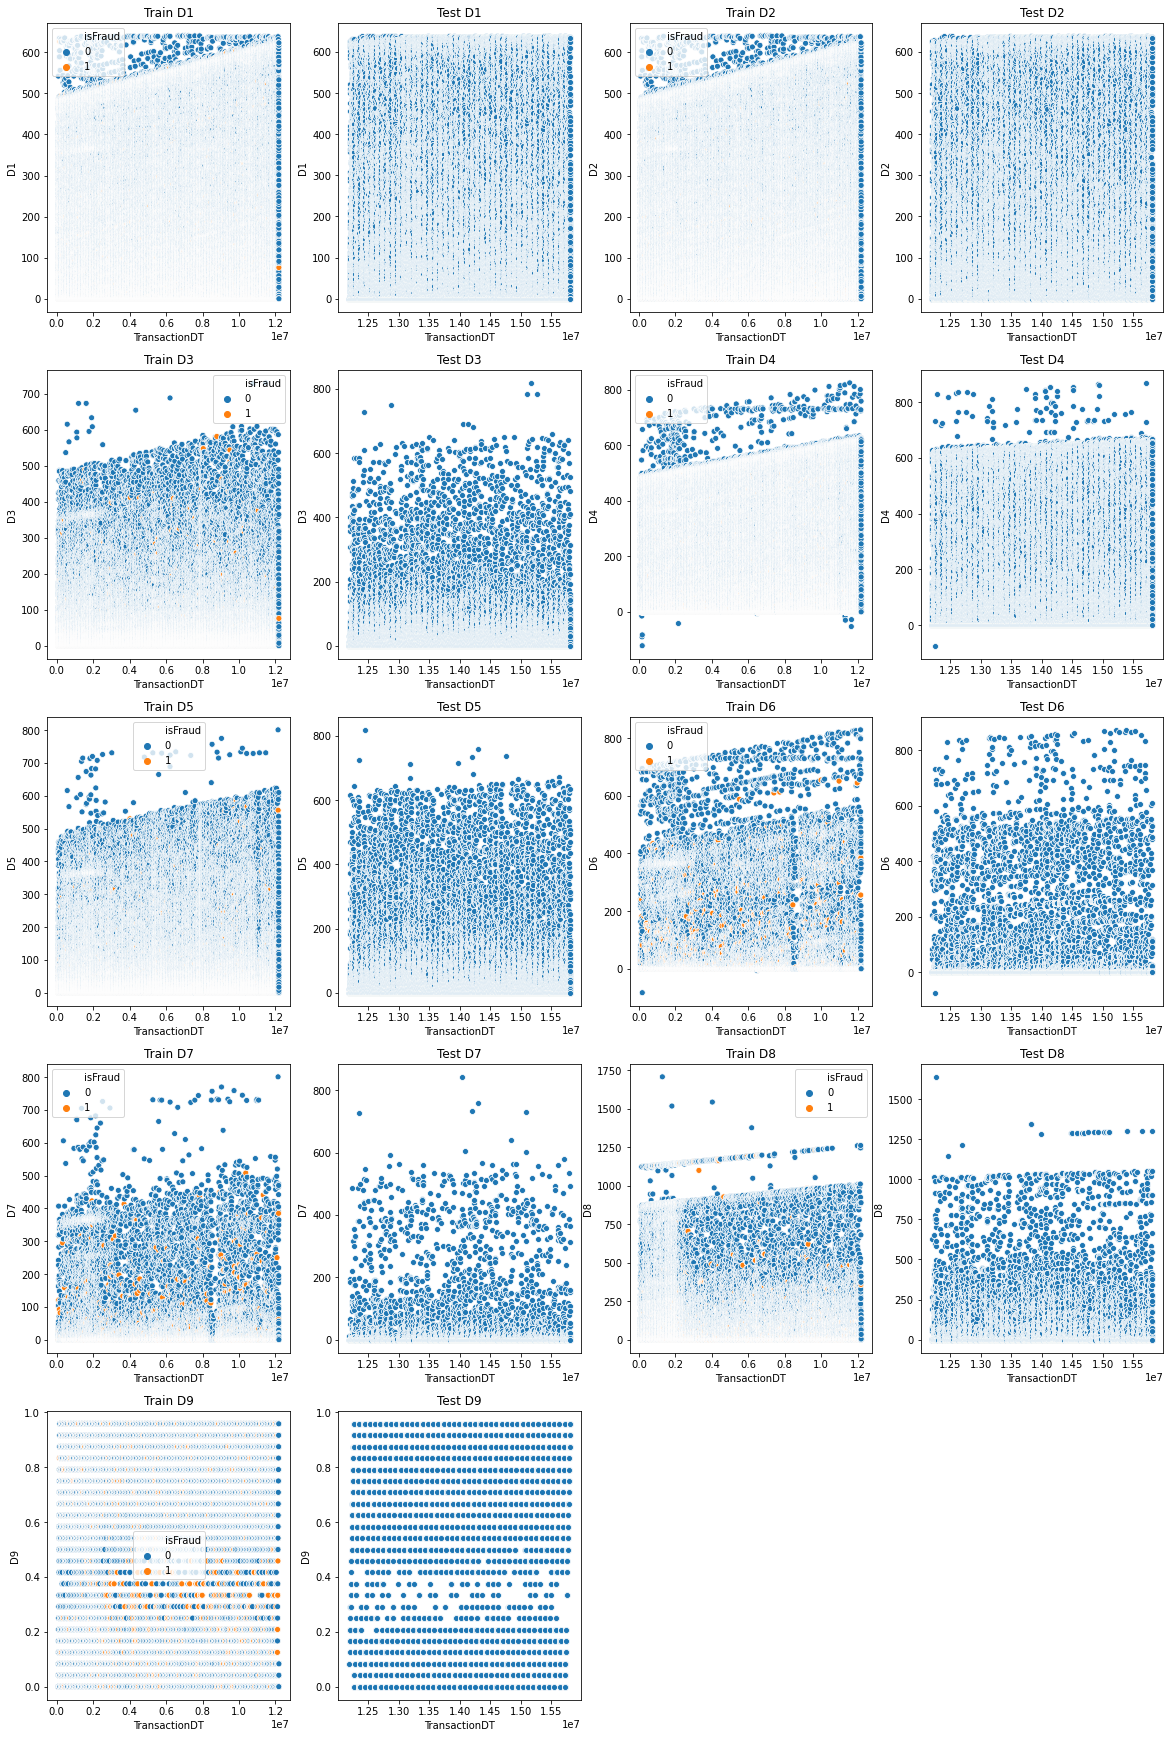

In [100]:
plt.figure(figsize=(20,50))
var = ['D' + str(i) for i in range(1,10)]
i = 1
for col in var:
    plt.subplot(8,4,i)
    sns.scatterplot(x="TransactionDT",y=col,hue="isFraud",data=train_original[~train_original[col].isnull()])
    plt.title('Train '+col)
    i += 1
    plt.subplot(8,4,i)
    sns.scatterplot(x="TransactionDT",y=col,data=test_original[~test_original[col].isnull()])
    plt.title('Test '+col)
    i += 1
plt.show()



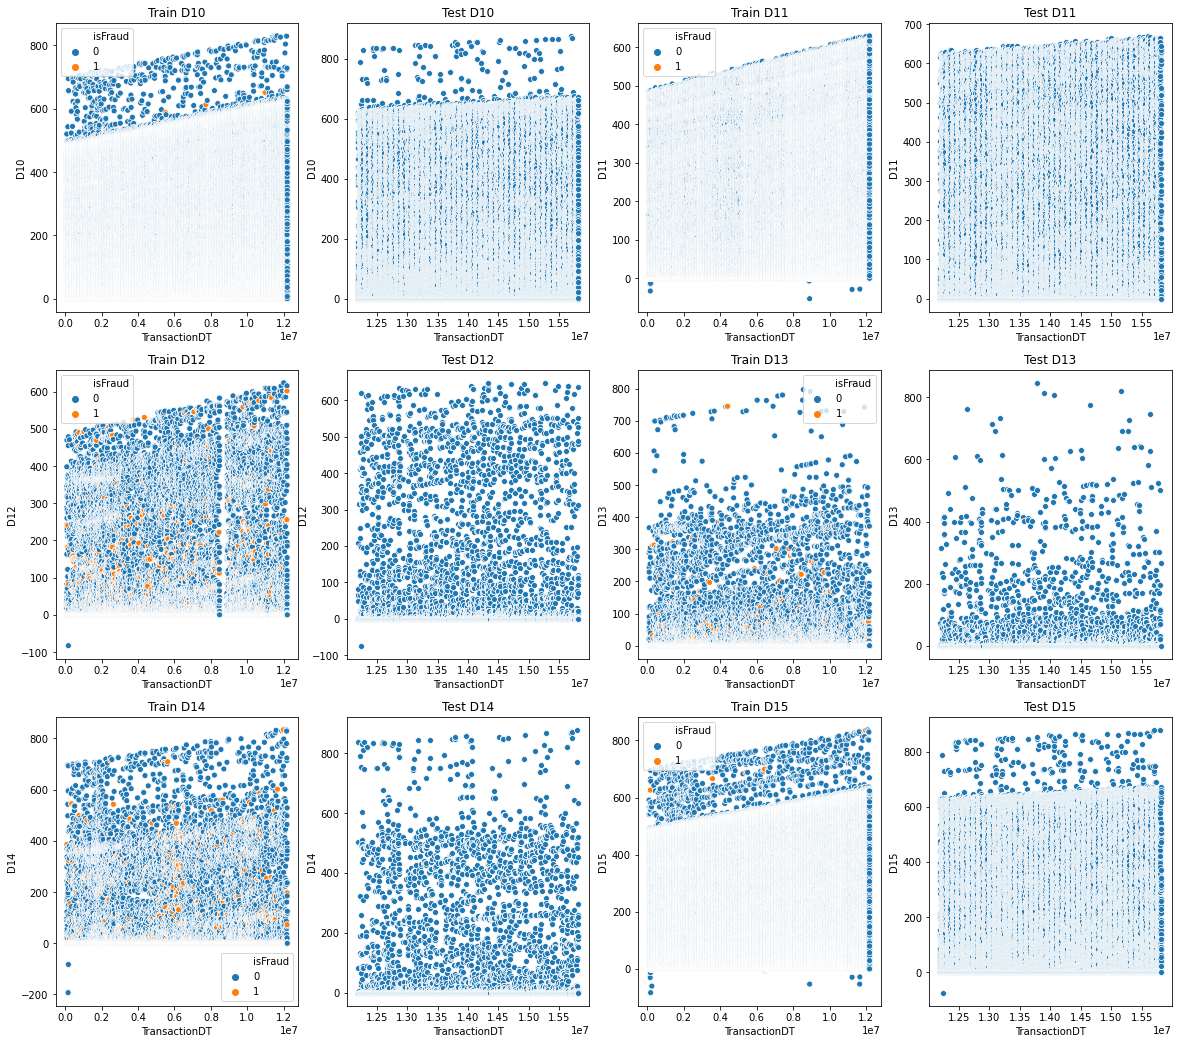

In [101]:
plt.figure(figsize=(20,50))
var = ['D' + str(i) for i in range(10,16)]
i = 1
for col in var:
    plt.subplot(8,4,i)
    sns.scatterplot(x="TransactionDT",y=col,hue="isFraud",data=train_original[~train_original[col].isnull()])
    plt.title('Train '+col)
    i += 1
    plt.subplot(8,4,i)
    sns.scatterplot(x="TransactionDT",y=col,data=test_original[~test_original[col].isnull()])
    plt.title('Test '+col)
    i += 1
plt.show()

Most of D features are increasing with TransactionDT

In [102]:
D_features = Data[['D1','D2','D3','D4','D5','D6','D7','D8'
                          ,'D9','D10','D11','D12','D13','D14','D15','isFraud']]

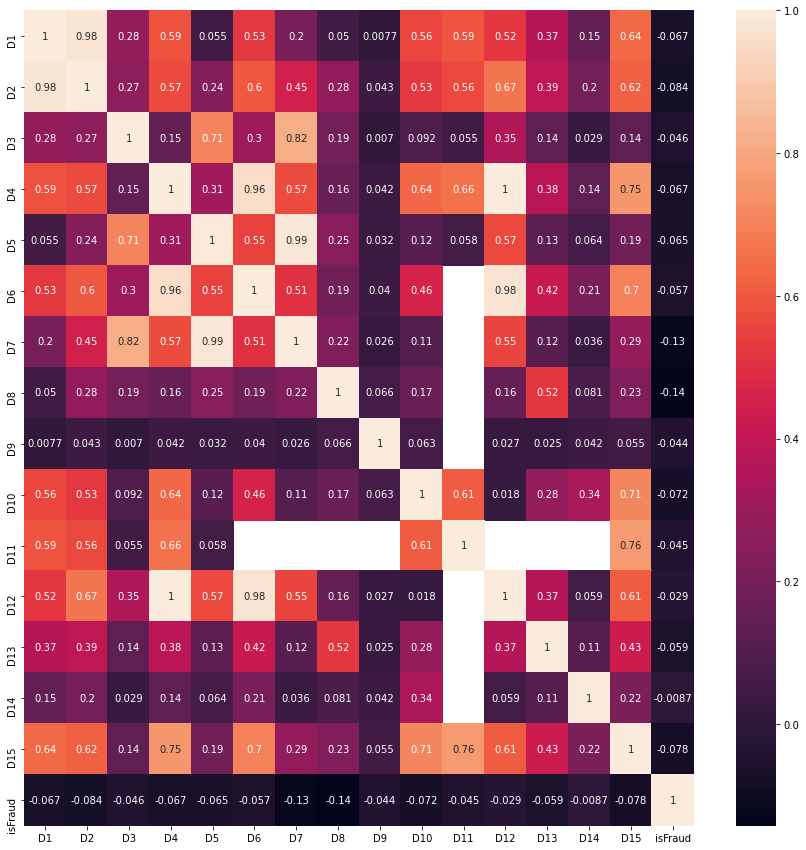

In [103]:
#checking correlation between D features
plt.figure(figsize=(15,15))
sns.heatmap(D_features.corr(),annot=True)

In [104]:
#C features
for i in range(1, 15):
    print(Data['C' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')

1.0    0.536443
2.0    0.177924
3.0    0.086895
4.0    0.048845
5.0    0.030348
Name: C1, dtype: float64


1.0    0.535545
2.0    0.176022
3.0    0.087666
4.0    0.047839
5.0    0.028738
Name: C2, dtype: float64


0.0    0.995887
1.0    0.003619
2.0    0.000305
3.0    0.000098
4.0    0.000012
Name: C3, dtype: float64


0.0    0.765203
1.0    0.189347
2.0    0.022004
3.0    0.008380
4.0    0.003221
Name: C4, dtype: float64


0.0    0.630669
1.0    0.208086
2.0    0.058888
3.0    0.022334
4.0    0.011562
Name: C5, dtype: float64


1.0    0.578372
2.0    0.145804
0.0    0.083087
3.0    0.060098
4.0    0.030150
Name: C6, dtype: float64


0.0    0.885871
1.0    0.087997
2.0    0.012385
3.0    0.003443
4.0    0.001878
Name: C7, dtype: float64


0.0    0.758064
1.0    0.177793
2.0    0.026970
3.0    0.009302
4.0    0.004770
Name: C8, dtype: float64


1.0    0.387676
0.0    0.311232
2.0    0.131793
3.0    0.055043
4.0    0.027426
Name: C9, dtype: float64


0.0    0.767843
1.0    0.169728
2.0  

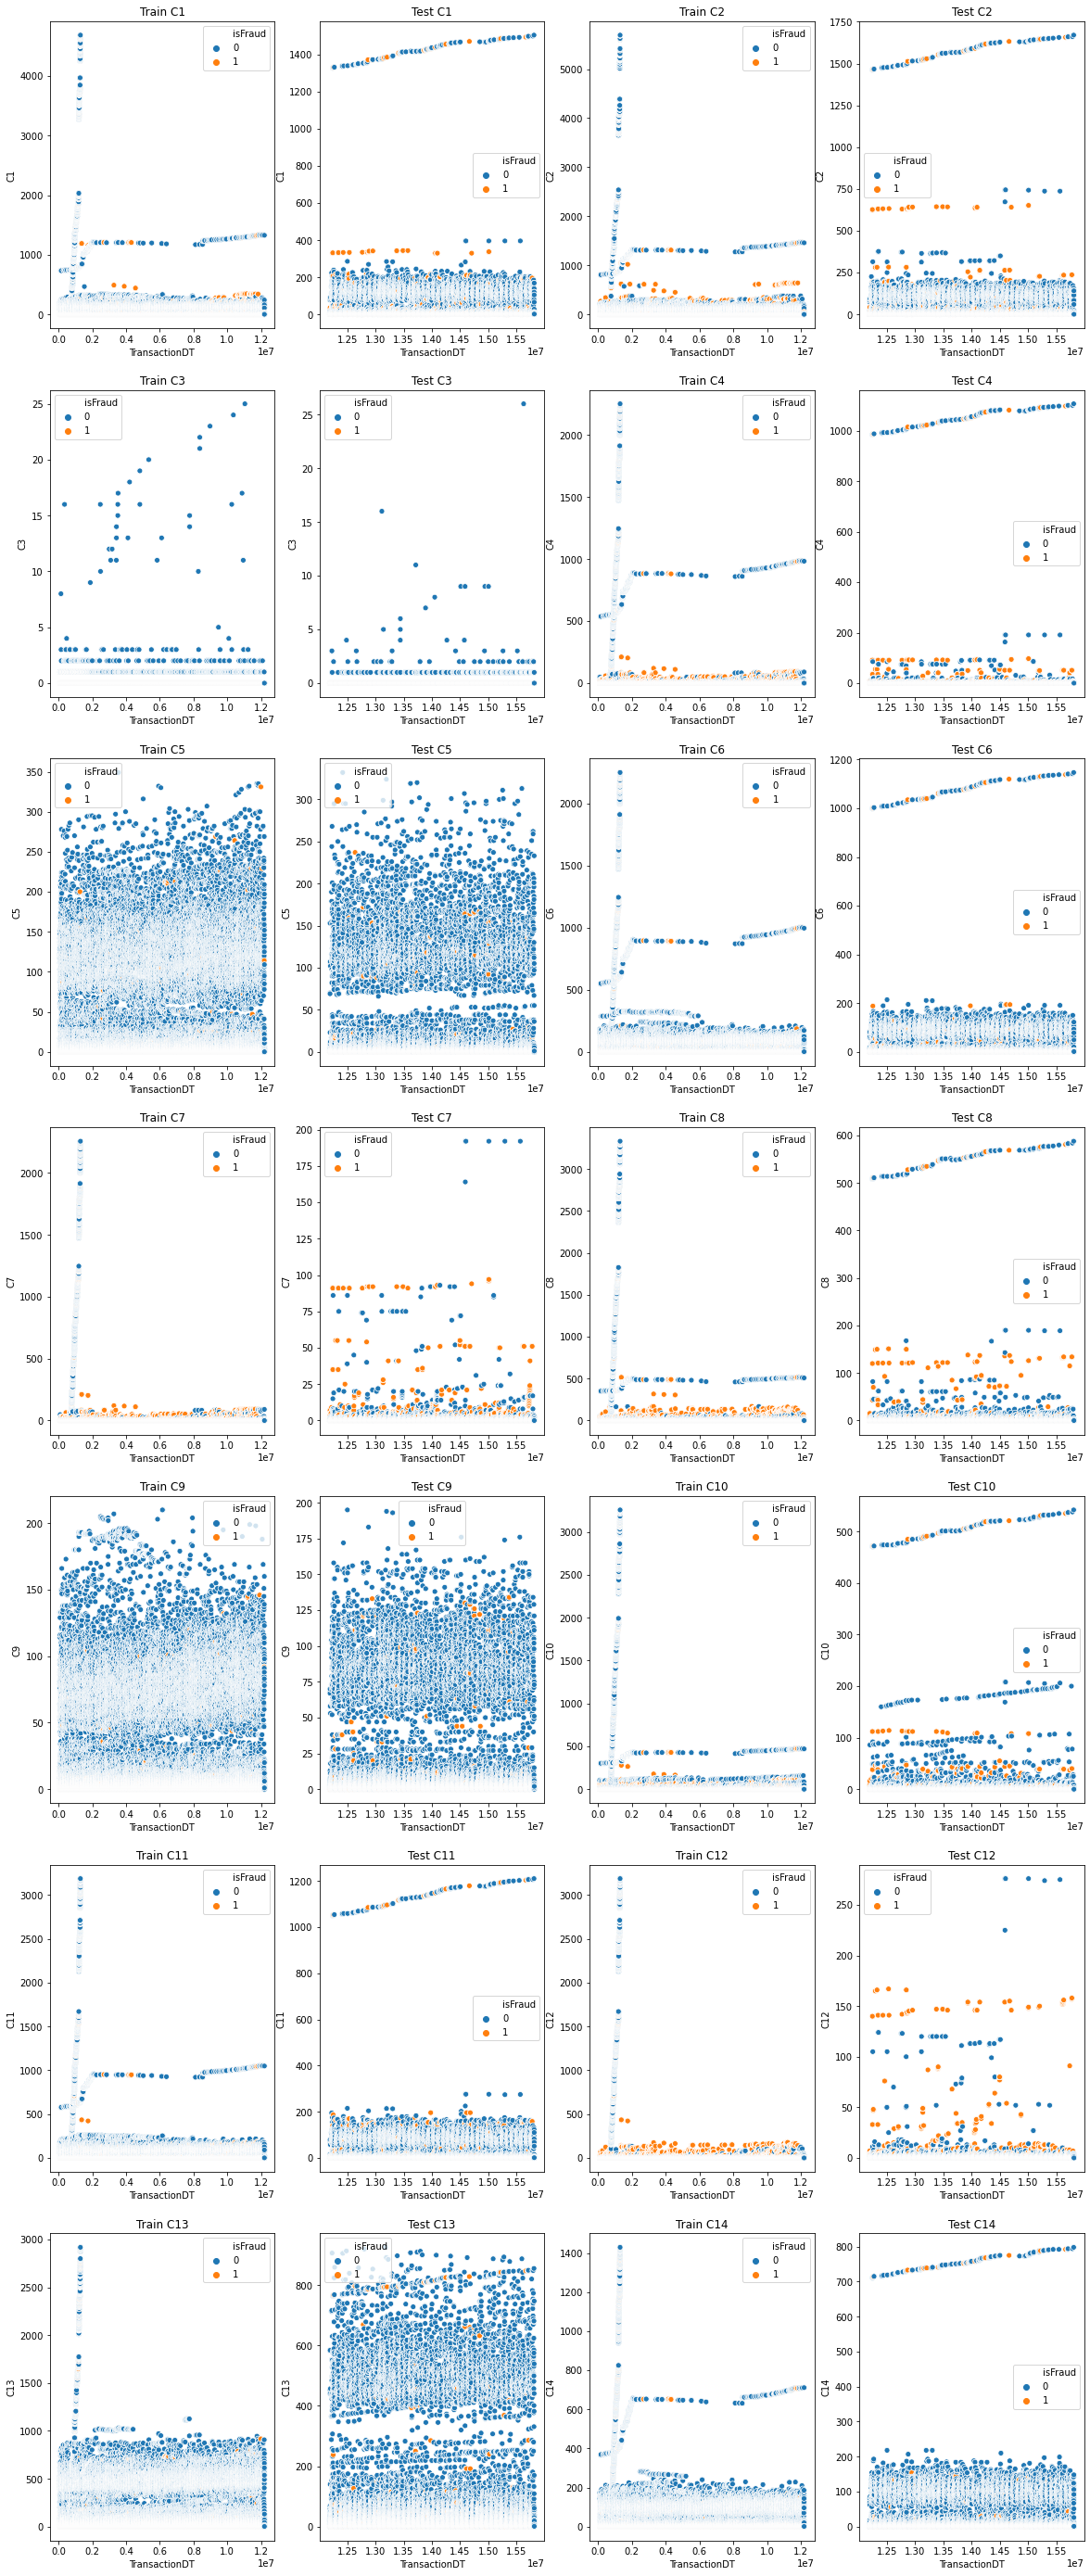

In [105]:

plt.figure(figsize=(20,50))
var = ['C' + str(i) for i in range(1,15)]
i = 1
for col in var:
    plt.subplot(7,4,i)
    sns.scatterplot(x="TransactionDT",y=col,hue="isFraud",data=train_original[~train_original[col].isnull()])
    plt.title('Train '+ col)
    i += 1
    plt.subplot(7,4,i)
    sns.scatterplot(x="TransactionDT",y=col,hue="isFraud",data=test_original[~test_original[col].isnull()])
    plt.title('Test '+ col)
    i += 1
plt.show()

In [106]:
C_features = Data[['C1','C2','C3','C4','C5','C6','C7','C8',
                         'C9','C10','C11','C12','C13','C14','isFraud']]

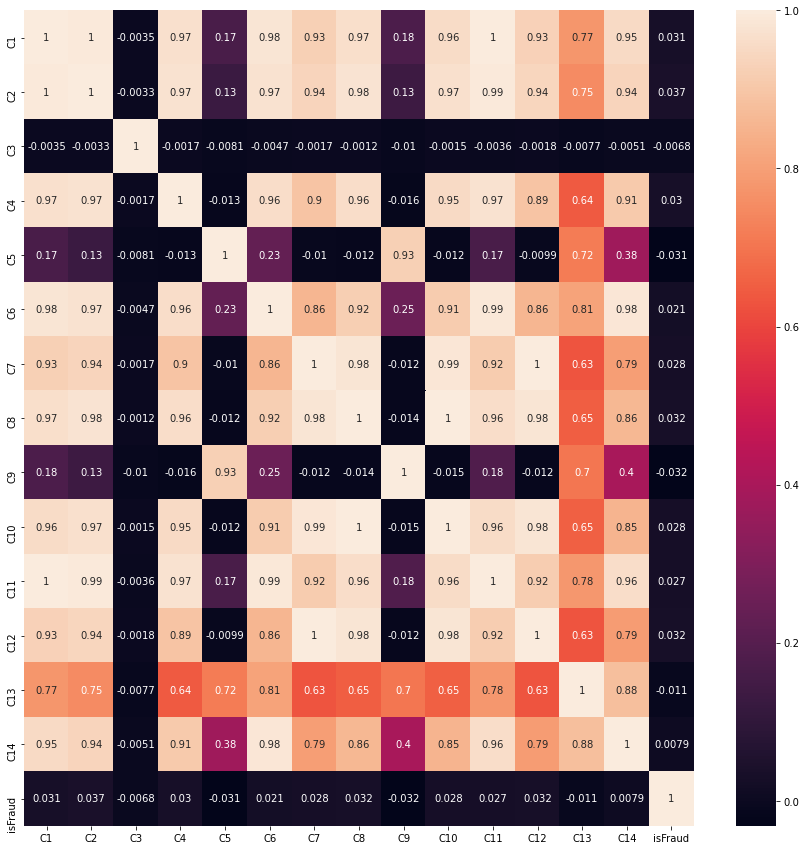

In [107]:
#Checking correlation between C features
plt.figure(figsize=(15,15))
sns.heatmap(C_features.corr(),annot=True)

Many C features are highly correlated with each other.

In [108]:
# Cleaning infinite values to NaN
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   


Data = clean_inf_nan(Data)

In [109]:
#replacing NaN with arbitary value
def fillna(df):
    df.fillna(-999, inplace = True)
    
fillna(Data)

In [110]:
Data.shape

(590540, 450)

In [111]:
##dropping some columns
Data.drop('R_emaildomain', axis=1, inplace=True)
Data.drop('P_emaildomain', axis=1, inplace=True)
Data.drop('card1', axis=1, inplace=True)
Data.drop('card2', axis=1, inplace=True)
Data.drop('card3', axis=1, inplace=True)
Data.drop('card5', axis=1, inplace=True)
Data.drop('version_id_30', axis=1, inplace=True)
Data.drop('version_id_31', axis=1, inplace=True)
Data.drop('screen_width', axis=1, inplace=True)
Data.drop('screen_height', axis=1, inplace=True)
Data.drop('dist1', axis=1, inplace=True)
Data.drop('dist2', axis=1, inplace=True)
Data.drop('id_23', axis=1, inplace=True)
Data.drop('id_27', axis=1, inplace=True)
Data.drop('interval_time', axis=1, inplace=True)
Data.drop('TransactionAmt', axis=1, inplace=True)
Data.drop('device_version', axis=1, inplace=True)

In [112]:
#checking categorical variables after feature engineering
cat_variables = list(Data.select_dtypes(include=['object']).columns)
cat_variables

['ProductCD',
 'card4',
 'card6',
 'addr1',
 'addr2',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_15',
 'id_16',
 'id_28',
 'id_29',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'P_emaildomain_bin',
 'P_emaildomain_suffix',
 'R_emaildomain_bin',
 'R_emaildomain_suffix',
 'OS_id_30',
 'browser_id_31',
 'device_name']

In [113]:
#missing value imputation of categorical variables with mode
for i in Data.columns: 
    if Data[i].dtypes=='object': Data[i].fillna(Data[i].mode()[0],inplace=True)
        
      

Label Encoding

In [114]:
from sklearn.preprocessing import LabelEncoder, minmax_scale

In [115]:
categorical_cols = ['ProductCD','card4','card6','addr1','addr2',
       'M1','M2','M3','M4','M5','M6','M7','M8','M9','id_12','id_15','id_16','id_23','id_27','id_28',
        'id_29','id_34','id_35','id_36','id_37','id_38','DeviceType','P_emaildomain_suffix', 'R_emaildomain_suffix','P_emaildomain_bin','R_emaildomain_bin',
                    'OS_id_30',
        'browser_id_31','device_name']
for col in categorical_cols:
    if col in Data.columns:
        le = LabelEncoder()
        le.fit(list(Data[col].astype(str).values)) 
        Data[col] = le.transform(list(Data[col].astype(str).values))

In [116]:
# Cleaning infinite values to NaN
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   
Data = clean_inf_nan(Data)

In [117]:
#replacing NaN
def fillna(df):
    df.fillna(-999, inplace = True)
    fillna(Data)

In [118]:
Data.shape

(590540, 433)

In [119]:
#train-test split
##80%-20%
Data['TransactionDT'].sort_values(ascending = True)
train =Data[:472432]
test= Data[472432:]



In [120]:
train.shape

(472432, 433)

In [121]:
test.shape

(118108, 433)

There are 433 features in the dataset after feature engineering. In this project,dimensionality reduction will be  done using various methods such as Principal component analysis-Feature extraction, Filter method Feature selection ,Wrapper method Feature selection, Embedded  and Hybrid Method.

In [122]:
#Creating copies for doing dimensionality reduction using various methods.
train_1=train.copy()
test_1=test.copy()

train_2=train.copy()
test_2=test.copy()

1-- principal component analysis

In [123]:
X_trainpca=train_1.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
Y_trainpca = train_1.sort_values('TransactionDT')['isFraud']
X_testpca=test_1.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
Y_testpca = test_1.sort_values('TransactionDT')['isFraud']

In [124]:
from sklearn.preprocessing import StandardScaler

In [125]:
# Standardizing the features
X_trainpca = StandardScaler().fit_transform(X_trainpca)
X_testpca = StandardScaler().fit_transform(X_testpca)

In [126]:
from sklearn.decomposition import PCA
##choose the minimum number of principal components such that 95% of the variance is retained.
pca = PCA(.95)
principalComponents = pca.fit(X_trainpca)

In [127]:
train_principal = pca.transform(X_trainpca)
test_principal = pca.transform(X_testpca)

In [128]:
train_principal=pd.DataFrame(train_principal)
test_principal=pd.DataFrame(test_principal)
Y_trainpca=pd.DataFrame(Y_trainpca)
Y_testpca=pd.DataFrame(Y_testpca)

In [129]:
train_principal.shape,test_principal.shape,Y_trainpca.shape,Y_testpca.shape

((472432, 39), (118108, 39), (472432, 1), (118108, 1))

In [130]:
train_principal_=pd.concat([Y_trainpca,train_principal],axis=1)

In [131]:
train_principal_.shape

(472432, 40)

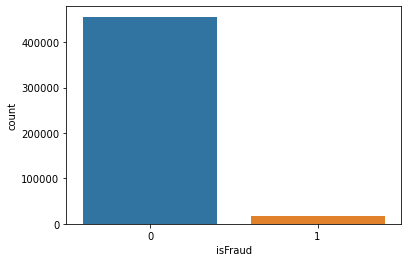

3.51 % are fraud transactions
96.49 % are legitimate transactions


0    455833
1     16599
Name: isFraud, dtype: int64

In [238]:
#checking target variable in training set
sns.countplot(Y_trainpca['isFraud'])
plt.show()
print(np.round(Y_trainpca[Y_trainpca['isFraud']==1].shape[0]/Y_trainpca.shape[0]*100,2),'% are fraud transactions')
print(np.round(Y_trainpca[Y_trainpca['isFraud']==0].shape[0]/Y_trainpca.shape[0]*100,2),'% are legitimate transactions')
Y_trainpca['isFraud'].value_counts()

In [177]:
#resampling of training set using combination of SMOTE and Random Undersampling.

In [279]:
pipe = make_pipeline(
    SMOTE(sampling_strategy=0.2),
    RandomUnderSampler(sampling_strategy=0.9)           
)

In [280]:
train_principal.var()
Y_trainpca.var()

isFraud    0.033901
dtype: float64

In [281]:
X_pcatrain,Y_pcatrain=pipe.fit_resample(train_principal,Y_trainpca)

In [282]:
X_pcatrain_=pd.DataFrame(X_pcatrain)
Y_pcatrain_=pd.DataFrame(Y_pcatrain)

In [283]:
train_principal_=pd.concat([X_pcatrain_,Y_pcatrain_],axis=1)
# Shuffle dataframe rows
trainpca = train_principal_.sample(frac=1, random_state=60)

Distribution of the Classes in the subsample dataset
0    0.526314
1    0.473686
Name: isFraud, dtype: float64


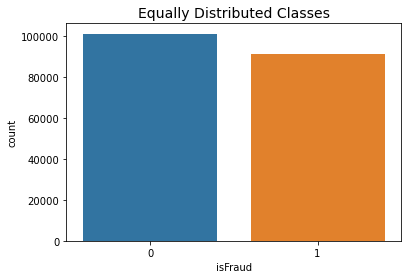

In [284]:
print('Distribution of the Classes in the subsample dataset')
print(trainpca['isFraud'].value_counts()/len(trainpca))
sns.countplot('isFraud', data=trainpca)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [285]:
X_pcatrain=trainpca.drop('isFraud', axis=1)
Y_pcatrain=trainpca['isFraud']

X_pcatest=test_principal
Y_pcatest=Y_testpca


In [286]:
#Logistic Regression

In [287]:
#first standardize the data
sc = StandardScaler()
X_pcatrain = sc.fit_transform(X_pcatrain)
X_pcatest = sc.fit_transform(X_pcatest)

In [288]:
#lets try with first default value
clf = SGDClassifier(loss="log")
clf.fit(X_pcatrain,Y_pcatrain)
y_trainpredprobpca=clf.predict_proba(X_pcatrain)
y_testpredprobpca = clf.predict_proba(X_pcatest)

In [289]:
#auc score with default values
print('auc of train with default parameter:',roc_auc_score(Y_pcatrain,y_trainpredprobpca[:,1]))
print('auc of test with  default parameter:',roc_auc_score(Y_pcatest,y_testpredprobpca[:,1]))

auc of train with default parameter: 0.7901562047443746
auc of test with  default parameter: 0.7619739450956491


In [290]:
##GridsearchCV with Timeseries

time_splitter_outer = TimeSeriesSplit(n_splits = 5)
time_splitter_inner = TimeSeriesSplit(n_splits = 5)

model = SGDClassifier(loss="log")
params = {
         'alpha':[10**-6,10**-5,10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3],#learning rate
         'penalty':['l1','l2']
         }

gs_SD = GridSearchCV(model, param_grid = params, cv = time_splitter_inner, scoring = 'roc_auc',verbose=10, n_jobs=-1)

In [291]:
gs_SD.fit(X_pcatrain,Y_pcatrain)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   15.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.9s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=SGDClassifier(loss='log'), n_jobs=-1,
             param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                   10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=10)

In [292]:
SDG_scores = cross_val_score(gs_SD, X_pcatrain,Y_pcatrain, cv = time_splitter_outer, scoring = 'roc_auc').mean()
print(SDG_scores)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1862s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    2.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.0s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    5.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    8.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.7s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   10.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.3s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   12.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.1s finished


0.7931678562078357


In [293]:
# Best values of the hyperparameters
penalty_best = gs_SD.best_estimator_.penalty
alpha_best = gs_SD.best_estimator_.alpha

In [294]:
SGD = SGDClassifier(penalty=penalty_best,
                           alpha = alpha_best,loss='log')
SGD.fit(X_pcatrain,Y_pcatrain)

SGDClassifier(alpha=0.001, loss='log')

In [295]:
#auc score after parameter tuning
y_trainpredprobpcasd=SGD.predict_proba(X_pcatrain)
y_testpredprobpcasd =SGD.predict_proba(X_pcatest)
print('train auc:',roc_auc_score(Y_pcatrain,y_trainpredprobpcasd[:,1]))
print('test auc:',roc_auc_score(Y_pcatest,y_testpredprobpcasd[:,1]))

train auc: 0.7955719998210178
test auc: 0.7695629421211096


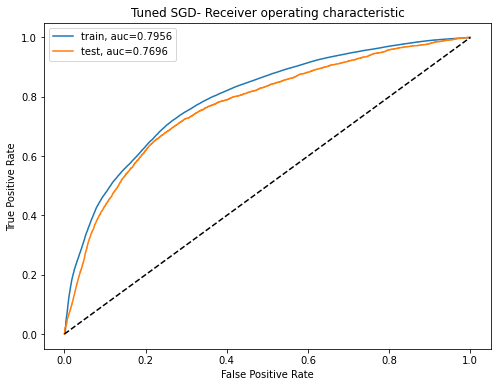

In [296]:
plt.figure(figsize=(8,6))
# auc of train
fpr, tpr, thresh = roc_curve(Y_pcatrain,y_trainpredprobpcasd[:,1])
auc = roc_auc_score(Y_pcatrain, y_trainpredprobpcasd[:,1])
plt.plot(fpr,tpr,label="train, auc="+str(round(auc,4)))
# auc of test
fpr, tpr, thresh = roc_curve(Y_pcatest,  y_testpredprobpcasd[:,1])
auc = roc_auc_score(Y_pcatest,  y_testpredprobpcasd[:,1])
plt.plot(fpr,tpr,label="test, auc="+str(round(auc,4)))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc=0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned SGD- Receiver operating characteristic')
plt.show()

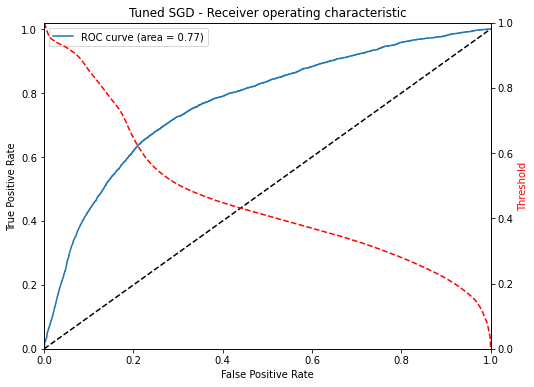

In [297]:
y_scores = y_testpredprobpcasd[:,1]
fpr, tpr, thresholds = roc_curve(Y_pcatest, y_scores)
# auc(fpr, tpr) # auc has been assigned as a variable by the above plot's code
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned SGD - Receiver operating characteristic')
plt.legend(loc="best")

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],1])
ax2.set_xlim([fpr[0],fpr[-1]])
plt.show()
# plt.axhline(y=0.0, c="r", ls="--", lw=2)
# plt.axvline(x=4.0, c="r", ls="--", lw=2)

In [298]:
y_trainpredpcasd=SGD.predict(X_pcatrain)
y_testpredpcasd= SGD.predict(X_pcatest)

In [299]:
print("Accuracy:\n",metrics.accuracy_score(Y_pcatest,y_testpredpcasd))
print("Recall:\n",metrics.recall_score(Y_pcatest,y_testpredpcasd))

Confusion Matrix:
 [[79317 34727]
 [ 1106  2958]]
Accuracy:
 0.6966081891150473
Recall:
 0.7278543307086615


In [300]:
#confusion matrix
cm_train = confusion_matrix(Y_pcatrain,y_trainpredpcasd)
cm_test  =confusion_matrix(Y_pcatest,y_testpredpcasd)

Text(0.5, 1.0, 'test')

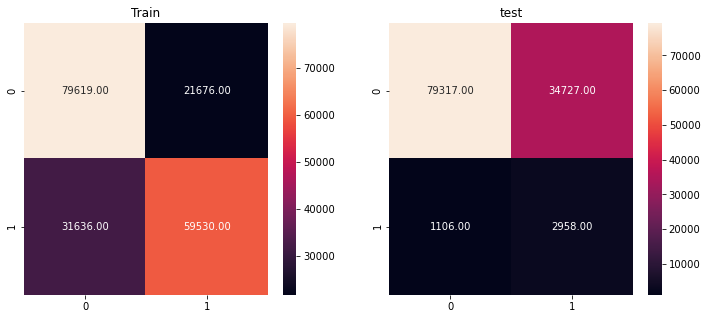

In [301]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(cm_train,annot=True,fmt='.2f')
plt.title('Train')
plt.subplot(1,2,2)
sns.heatmap(cm_test,annot=True,fmt='.2f')
plt.title('test')

In [302]:
#matthews correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(Y_pcatrain, y_trainpredpcasd)
matthews_corrcoef(Y_pcatest, y_testpredpcasd)

0.16555308097427318

In [303]:
#Random Forest

In [304]:
# with default paramter
clf = RandomForestClassifier()
clf.fit(X_pcatrain,Y_pcatrain)
y_trainpredprobpcarf=clf.predict_proba(X_pcatrain)
y_testpredprobpcarf = clf.predict_proba(X_pcatest)

In [305]:
#auc score with deafult values
print('random forest train auc with default parameters:', roc_auc_score(Y_pcatrain, y_trainpredprobpcarf[:,1]))
print('andom forest test auc with default parameters:', roc_auc_score(Y_pcatest, y_testpredprobpcarf[:,1]))

random forest train auc with default parameters: 1.0
andom forest test auc with default parameters: 0.7351713992589405


In [306]:
#GridSearchCV with timeseries

time_splitter_outer = TimeSeriesSplit(n_splits = 3)
time_splitter_inner = TimeSeriesSplit(n_splits = 3)

model=RandomForestClassifier()
params = {'n_estimators':[500,700,900,1000],
           'max_depth':[3,5,7,9,11,13]}

gs_rf = GridSearchCV(model, param_grid = params, cv = time_splitter_inner, scoring = 'roc_auc',verbose=10, n_jobs=-1)



In [307]:
gs_rf.fit(X_pcatrain,Y_pcatrain)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 26.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 39.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 53.2min
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed: 65.0min remaining:  7.0min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 79.4min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9, 11, 13],
                         'n_estimators': [500, 700, 900, 1000]},
             scoring='roc_auc', verbose=10)

In [308]:
forest_scores = cross_val_score(gs_rf, X_pcatrain,Y_pcatrain, cv = time_splitter_outer, scoring = 'roc_auc').mean()
print(forest_scores)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed: 14.1min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 17.2min finished


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed: 27.9min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 34.5min finished


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 28.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 38.8min
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed: 47.8min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 58.4min finished


0.9133233966265125


In [309]:
# Best values of the hyperparameters
max_depth_best = gs_rf.best_estimator_.max_depth
n_estimators_best = gs_rf.best_estimator_.n_estimators

In [310]:
rfc = RandomForestClassifier(max_depth = max_depth_best, n_estimators = n_estimators_best)
rfc.fit(X_pcatrain,Y_pcatrain)

RandomForestClassifier(max_depth=13, n_estimators=1000)

In [311]:
#auc score after parameter tuning
y_trainpredprobrf=rfc.predict_proba(X_pcatrain)
y_testpredprobrf =rfc.predict_proba(X_pcatest)
print('train auc:',roc_auc_score(Y_pcatrain,y_trainpredprobrf[:,1]))
print('test auc:',roc_auc_score(Y_pcatest,y_testpredprobrf[:,1]))

train auc: 0.9518493175228411
test auc: 0.7919289944763688


In [314]:
y_trainpredpcarf=rfc.predict(X_pcatrain)
y_testpredpcarf= rfc.predict(X_pcatest)

In [315]:
print("Accuracy:\n",metrics.accuracy_score(Y_pcatest,y_testpredpcarf))
print("Recall:\n",metrics.recall_score(Y_pcatest,y_testpredpcarf))

Accuracy:
 0.9020134114539236
Recall:
 0.43528543307086615


In [318]:
#matthews correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(Y_pcatrain, y_trainpredpcarf)
matthews_corrcoef(Y_pcatest, y_testpredpcarf)

0.22156118891762488

DATA PREPARATION 

In [343]:
X_train2 = train_2.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
X_test2 = test_2.sort_values('TransactionDT').drop(['isFraud','TransactionDT', 'TransactionID'], axis=1)
Y_train2 = train_2.sort_values('TransactionDT')['isFraud']
Y_test2 = test_2.sort_values('TransactionDT')['isFraud']

In [320]:
from sklearn.feature_selection import VarianceThreshold

In [321]:
#removing constant features using variance threshold
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(X_train2)

VarianceThreshold(threshold=0)

In [322]:
len(X_train2.columns[constant_filter.get_support()])

430

In [323]:
constant_columns = [column for column in X_train2.columns
                    if column not in X_train2.columns[constant_filter.get_support()]]

print(len(constant_columns))

0


In [324]:
for column in constant_columns:
    print(column)

In [325]:
X_train2 = constant_filter.transform(X_train2)
X_test2 = constant_filter.transform(X_test2)

X_train2.shape, X_test2.shape

((472432, 430), (118108, 430))

In [326]:
#Removing Quasi-Constant Features Using Variance Threshold

qconstant_filter = VarianceThreshold(threshold=0.01)

In [327]:
qconstant_filter.fit(X_train2)

VarianceThreshold(threshold=0.01)

In [328]:
X_train2=pd.DataFrame(X_train2)
X_test2=pd.DataFrame(X_test2)

In [329]:
len(X_train2.columns[qconstant_filter.get_support()])

430

In [330]:
qconstant_columns = [column for column in X_train2.columns
                    if column not in X_train2.columns[qconstant_filter.get_support()]]

print(len(qconstant_columns))

0


In [331]:
for column in qconstant_columns:
    print(column)

In [332]:
X_train2 = qconstant_filter.transform(X_train2)
X_test2 = qconstant_filter.transform(X_test2)

X_train2.shape, X_test2.shape

((472432, 430), (118108, 430))

In [346]:
X_train2=pd.DataFrame(X_train2)
X_test2=pd.DataFrame(X_test2)

In [347]:
#find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train2, 0.80)
print('correlated features: ', len(set(corr_features)) )

correlated features:  365


In [348]:
X_train2.drop(labels=corr_features, axis=1, inplace=True)
X_test2.drop(labels=corr_features, axis=1, inplace=True)

X_train2.shape, X_test2.shape

((472432, 65), (118108, 65))

In [362]:
X_train2.to_csv('X_train2.csv',index=False)
X_test2.to_csv('X_test2.csv',index=False)

In [365]:
Y_train2.to_csv('Y_train2.csv',index=False)
Y_test2.to_csv('Y_test2.csv',index=False)